In [1]:
import numpy as np
%pip install plotly==5.8.0
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sb
import statsmodels.api as sm
import plotly.express as px
from google.colab import files
%pip install kaleido
import kaleido
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from collections import Counter
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import metrics
from sklearn.metrics import r2_score,silhouette_score,confusion_matrix,accuracy_score
pd.set_option("display.precision",3)
np.set_printoptions(precision=5, suppress=True)
pd.options.display.float_format = '{:.4f}'.format
import plotly.io as pio

pio.renderers.default = "svg"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 17.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.4 MB/s eta 0:00:00


## Read the data

In [2]:
df = pd.read_csv('data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df['inr(10e3)'] = df['PriceEuro']*0.08320
df['RapidCharge'].replace(to_replace=['No','Yes'],value=[0, 1],inplace=True)
df.head()

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,inr(10e3)
0,Tesla,Model 3 Long Range Dual Motor,4.6000,233,450,161,940,1,AWD,Type 2 CCS,Sedan,D,5,55480,4615.9360
1,Volkswagen,ID.3 Pure,10.0000,160,270,167,250,0,RWD,Type 2 CCS,Hatchback,C,5,30000,2496.0000
2,Polestar,2,4.7000,210,400,181,620,1,AWD,Type 2 CCS,Liftback,D,5,56440,4695.8080
3,BMW,iX3,6.8000,180,360,206,560,1,RWD,Type 2 CCS,SUV,D,5,68040,5660.9280
4,Honda,e,9.5000,145,170,168,190,1,RWD,Type 2 CCS,Hatchback,B,4,32997,2745.3504


In [3]:
df[(df['Brand'] == 'Tesla ') | (df['Brand'] == 'BMW ')]

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,inr(10e3)
0,Tesla,Model 3 Long Range Dual Motor,4.6000,233,450,161,940,1,AWD,Type 2 CCS,Sedan,D,5,55480,4615.9360
3,BMW,iX3,6.8000,180,360,206,560,1,RWD,Type 2 CCS,SUV,D,5,68040,5660.9280
8,Tesla,Model 3 Standard Range Plus,5.6000,225,310,153,650,1,RWD,Type 2 CCS,Sedan,D,5,46380,3858.8160
13,BMW,i4,4.0000,200,450,178,650,1,RWD,Type 2 CCS,Sedan,D,5,65000,5408.0000
21,Tesla,Model Y Long Range Dual Motor,5.1000,217,425,171,930,1,AWD,Type 2 CCS,SUV,D,7,58620,4877.1840
24,Tesla,Model 3 Long Range Performance,3.4000,261,435,167,910,1,AWD,Type 2 CCS,Sedan,D,5,61480,5115.1360
28,BMW,i3 120 Ah,7.3000,150,235,161,270,0,RWD,Type 2 CCS,Hatchback,B,4,38017,3163.0144
33,Tesla,Cybertruck Tri Motor,3.0000,210,750,267,710,1,AWD,Type 2 CCS,Pickup,N,6,75000,6240.0000
40,Tesla,Model S Long Range,3.8000,250,515,184,560,1,AWD,Type 2,Liftback,F,5,79990,6655.1680
51,Tesla,Roadster,2.1000,410,970,206,920,1,AWD,Type 2 CCS,Cabrio,S,4,215000,17888.0000


## Information of the type of data in seach column

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    int64  
 7   RapidCharge      103 non-null    int64  
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  PriceEuro        103 non-null    int64  
 14  inr(10e3)        103 non-null    float64
dtypes: float64(2), int64(7), object(6)
memory usage: 12.2+ KB


## Finding out the number of null values

In [5]:
df.isnull().sum()

Brand              0
Model              0
AccelSec           0
TopSpeed_KmH       0
Range_Km           0
Efficiency_WhKm    0
FastCharge_KmH     0
RapidCharge        0
PowerTrain         0
PlugType           0
BodyStyle          0
Segment            0
Seats              0
PriceEuro          0
inr(10e3)          0
dtype: int64

## Descriptive Statistics of the dataset

In [6]:
df.describe()

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,Seats,PriceEuro,inr(10e3)
count,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000
mean,7.3961,179.1942,338.7864,189.1650,444.2718,0.7476,4.8835,55811.5631,4643.5221
std,3.0174,43.5730,126.0144,29.5668,203.9493,0.4365,0.7958,34134.6653,2840.0042
min,2.1000,123.0000,95.0000,104.0000,170.0000,0.0000,2.0000,20129.0000,1674.7328
25%,5.1000,150.0000,250.0000,168.0000,260.0000,0.5000,5.0000,34429.5000,2864.5344
50%,7.3000,160.0000,340.0000,180.0000,440.0000,1.0000,5.0000,45000.0000,3744.0000
75%,9.0000,200.0000,400.0000,203.0000,555.0000,1.0000,5.0000,65000.0000,5408.0000
max,22.4000,410.0000,970.0000,273.0000,940.0000,1.0000,7.0000,215000.0000,17888.0000


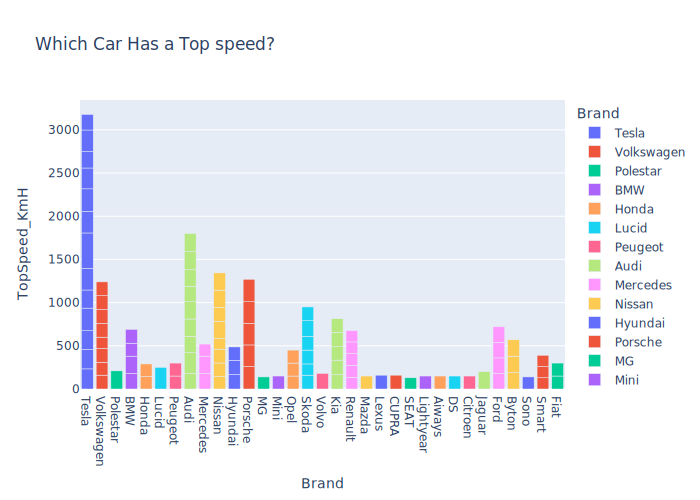

In [7]:
fig = px.bar(df,x='Brand',y = 'TopSpeed_KmH',color = 'Brand',title = 'Which Car Has a Top speed?',labels = {'x':'Car Brands','y':'Top Speed Km/H'})
pio.show(fig)

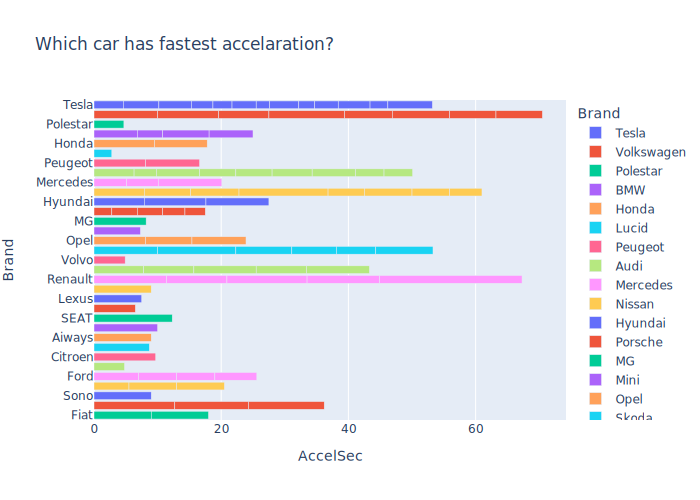

In [8]:
fig = px.bar(df,x='AccelSec',y = 'Brand',color = 'Brand',title = 'Which car has fastest accelaration?',labels = {'x':'Accelaration','y':'Car Brands'})
pio.show(fig)

<Axes: title={'center': 'Car Price'}, xlabel='No. of Samples', ylabel='Car Price'>

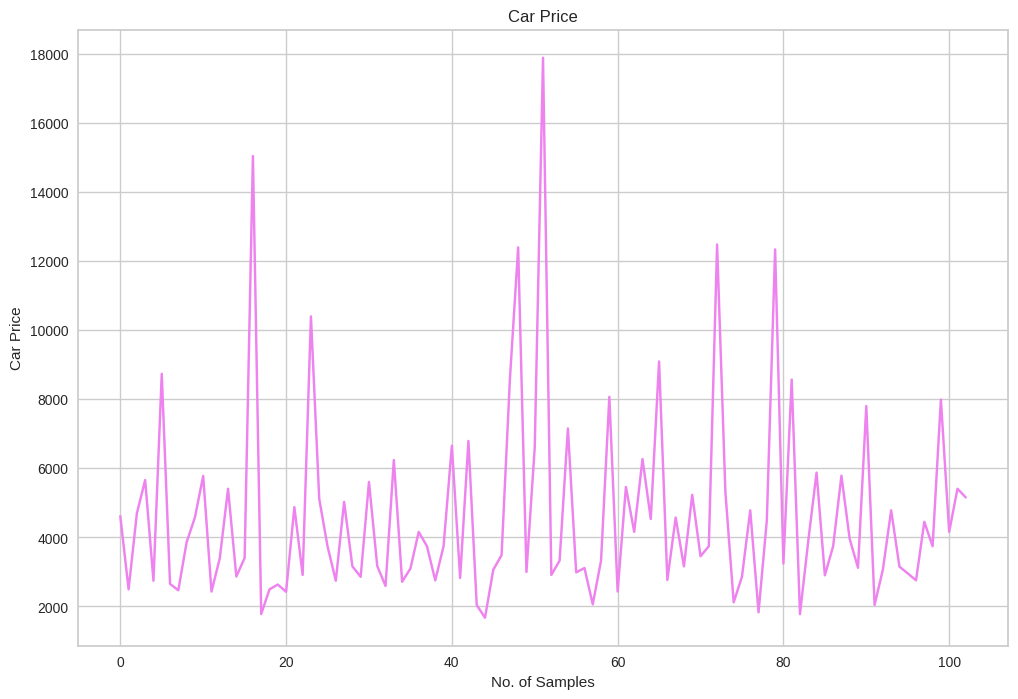

In [10]:
df['inr(10e3)'].plot(figsize = (12,8),title='Car Price',xlabel = 'No. of Samples',ylabel = 'Car Price',color = 'violet')

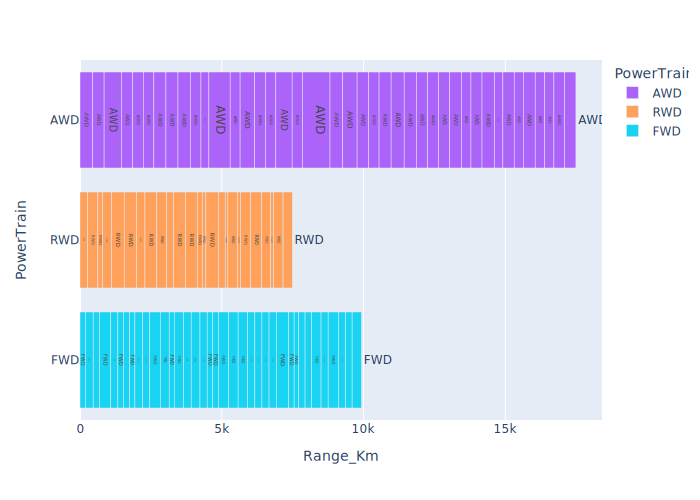

In [18]:
# fig = px.bar(df,x = 'Range_Km',y = 'PowerTrain',color = 'PowerTrain',text='PowerTrain')
# pio.show(fig)
color_discrete_map = {
    'PowerTrain1': 'blue',
    'PowerTrain2': 'red',
    'PowerTrain3': 'green'
    # Add more PowerTrain categories and their respective colors as needed
}

fig = px.bar(df, x='Range_Km', y='PowerTrain', color='PowerTrain', text='PowerTrain', color_discrete_map=color_discrete_map)
pio.show(fig)

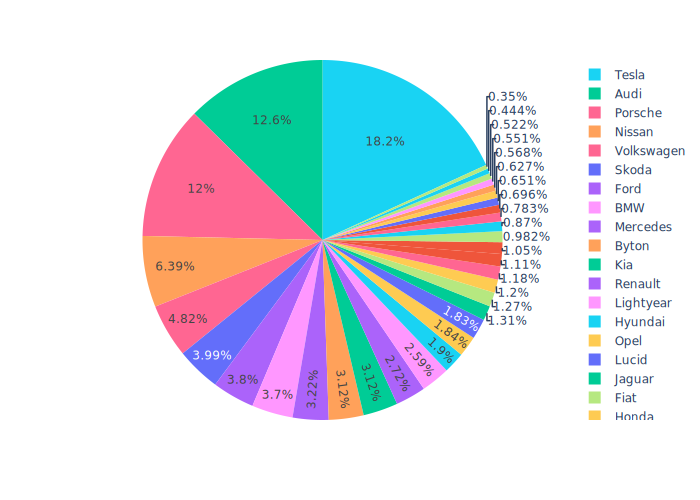

In [23]:
# fig = px.pie(df,names = 'Brand',values = 'inr(10e3)')
# pio.show(fig)
color_discrete_map = {
    'Brand1': 'green',
    'Brand2': 'yellow',
    'Brand3': 'violet',
     'Brand4' : 'red',
    'Brand5' : 'blue'
}

fig = px.pie(df, names='Brand', values='inr(10e3)', color='Brand', color_discrete_map=color_discrete_map)
pio.show(fig)


In [24]:
fig = px.scatter_3d(df,x = 'Brand',y = 'Seats',z = 'Segment',color='Brand')

In [25]:
fig = px.scatter_3d(df,x = 'Brand',y = 'AccelSec',z = 'inr(10e3)',color = 'Brand')

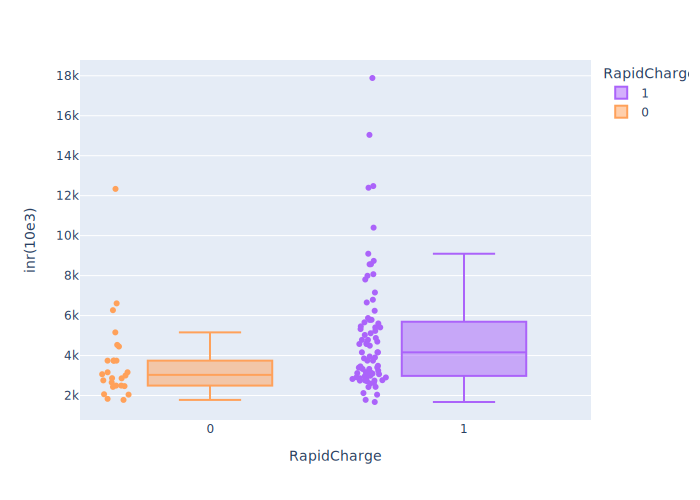

In [27]:
# fig = px.box(df,x='RapidCharge',y = 'inr(10e3)',color = 'RapidCharge',points='all')
# pio.show(fig)
color_discrete_map = {
    'RapidCharge1': 'blue',
    'RapidCharge2': 'red',
    'RapidCharge3': 'green'
}

fig = px.box(df, x='RapidCharge', y='inr(10e3)', color='RapidCharge', points='all', color_discrete_map=color_discrete_map)
pio.show(fig)

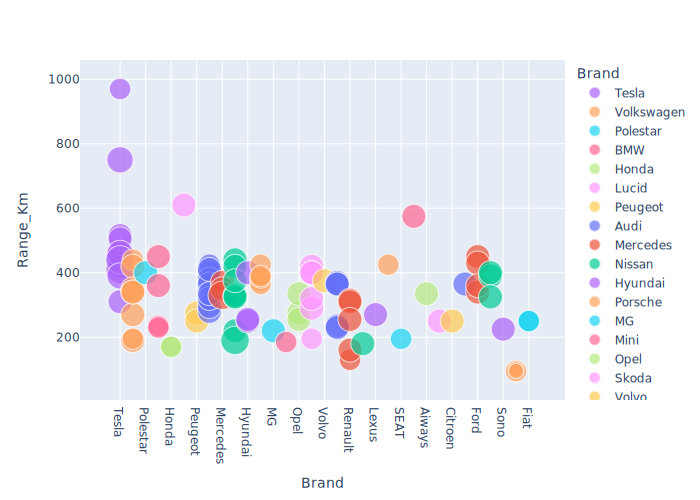

In [30]:
color_discrete_map = {
    'Brand1': 'pink',
    'Brand2': 'blue',
    'Brand3': 'yellow'
}

fig = px.scatter(df,
                 x='Brand',
                 y='Range_Km',
                 size='Seats',
                 color='Brand',
                 hover_data=['RapidCharge', 'inr(10e3)'],
                 color_discrete_map=color_discrete_map)
pio.show(fig)


## Pairplot of all the columns based on Rapid Charger presence

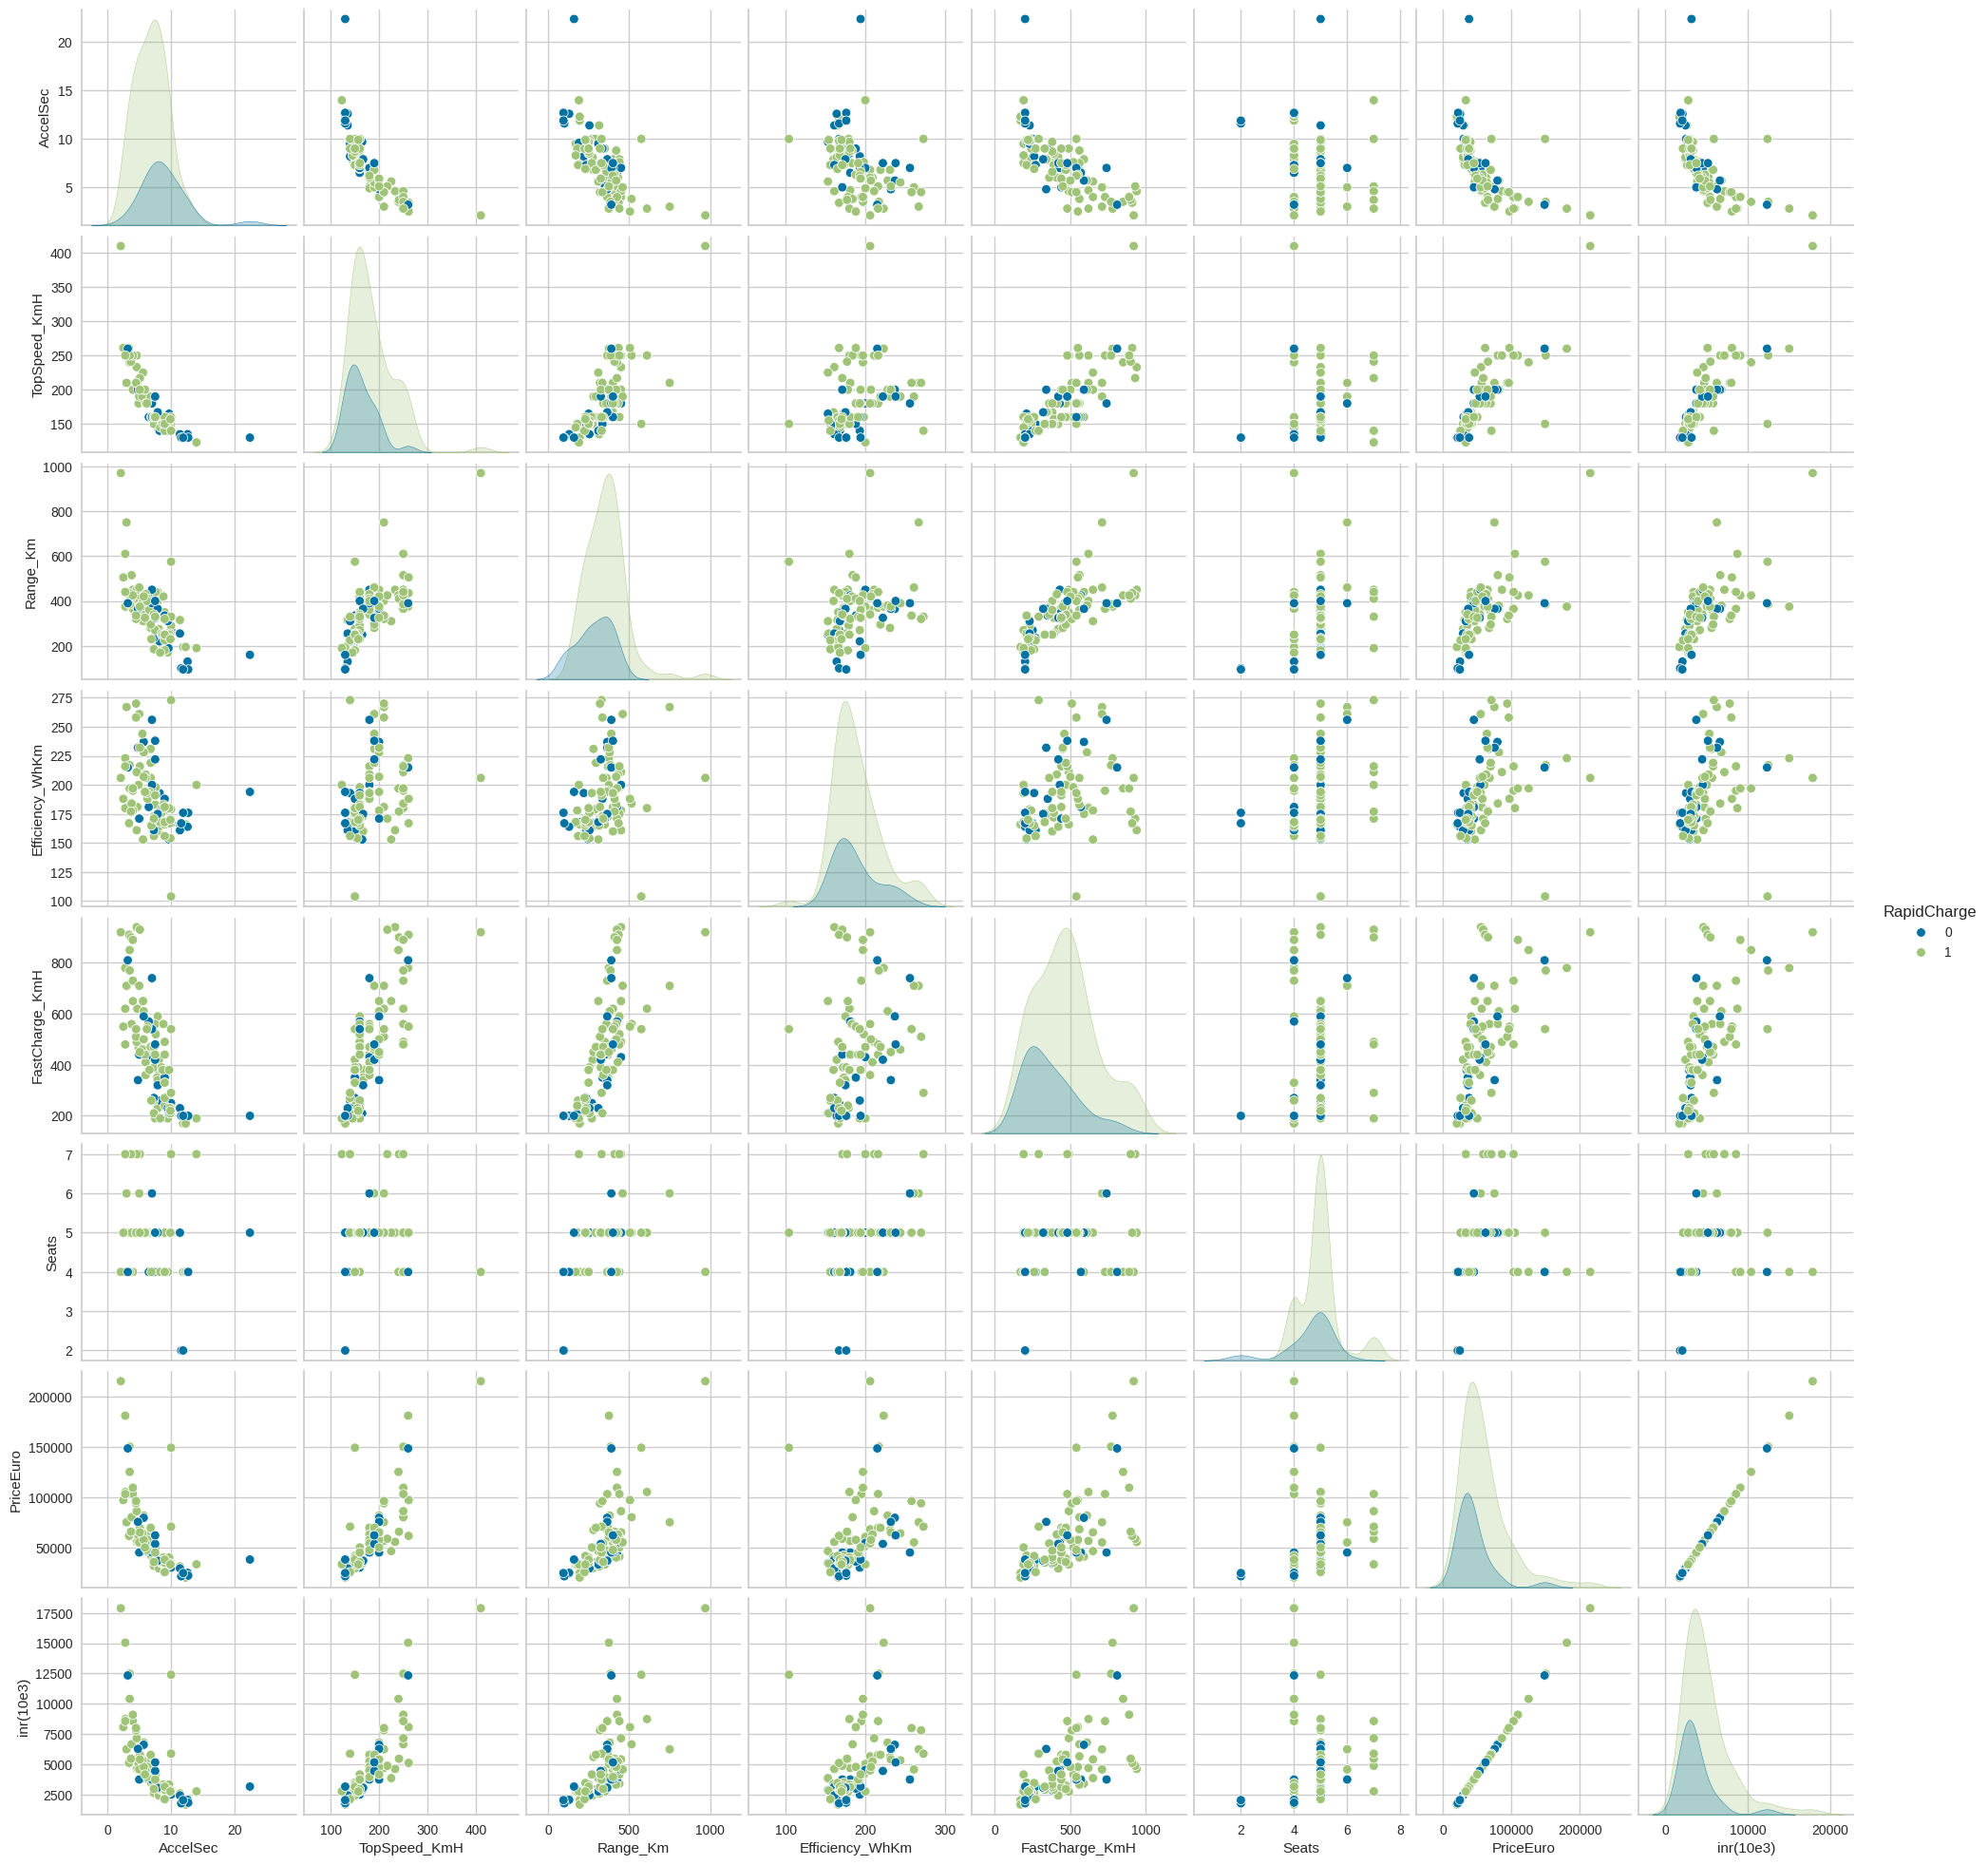

In [33]:
sb.pairplot(df,hue='RapidCharge')

## Heatmap to show the correlation of the data

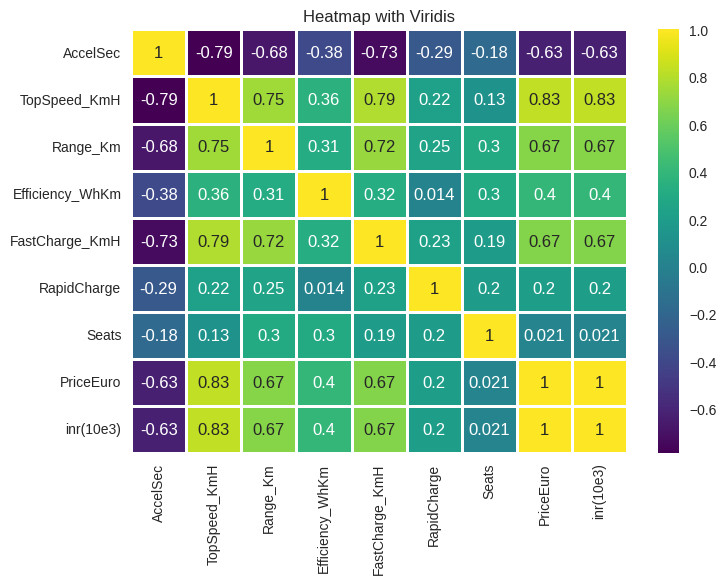

In [39]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

sb.heatmap(numeric_df.corr(), linewidths=1, linecolor='white', annot=True, cmap='viridis')
plt.title('Heatmap with Viridis')
plt.show()



In [40]:
a=np.arange(1,104)

# Making Some Comparisions for our dataset


## Frequency of the Brands in the dataset

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32

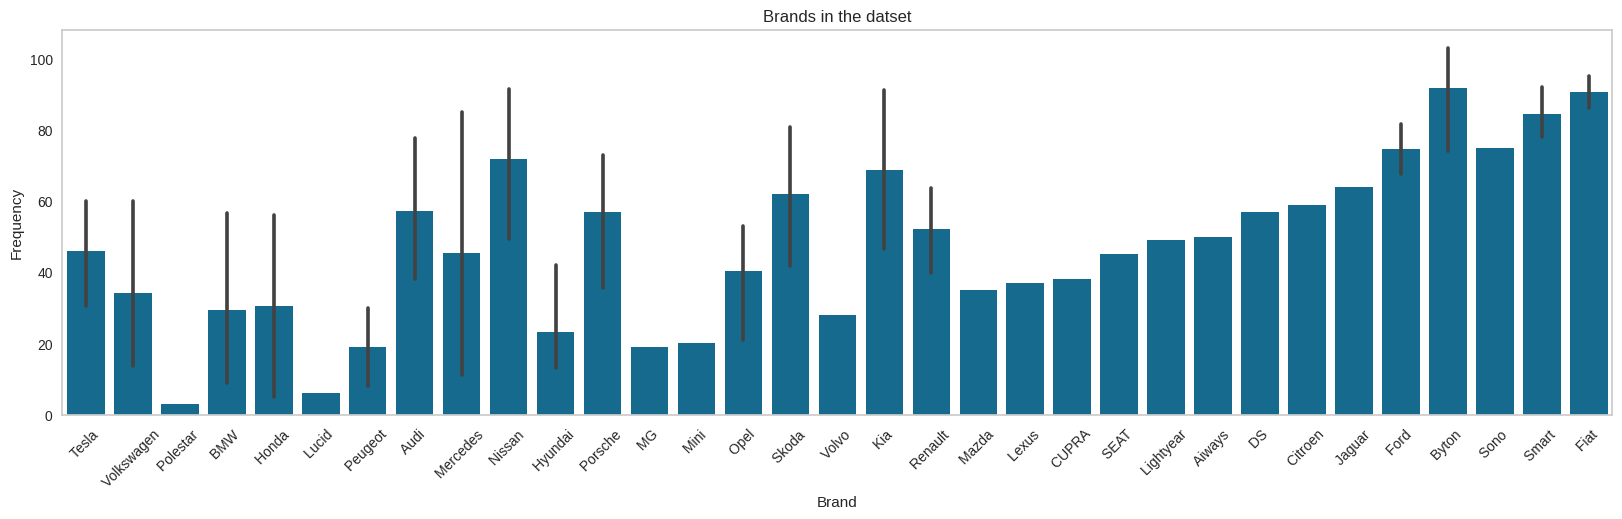

In [43]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y=a,data=df)
plt.grid(axis='y')
plt.title('Brands in the datset')
plt.xlabel('Brand')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

Byton , Fiat and smart are the prominent brands and Polestar being the least


## Top speeds achieved by the cars of a brand

<ipython-input-44-d743777476d9>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32

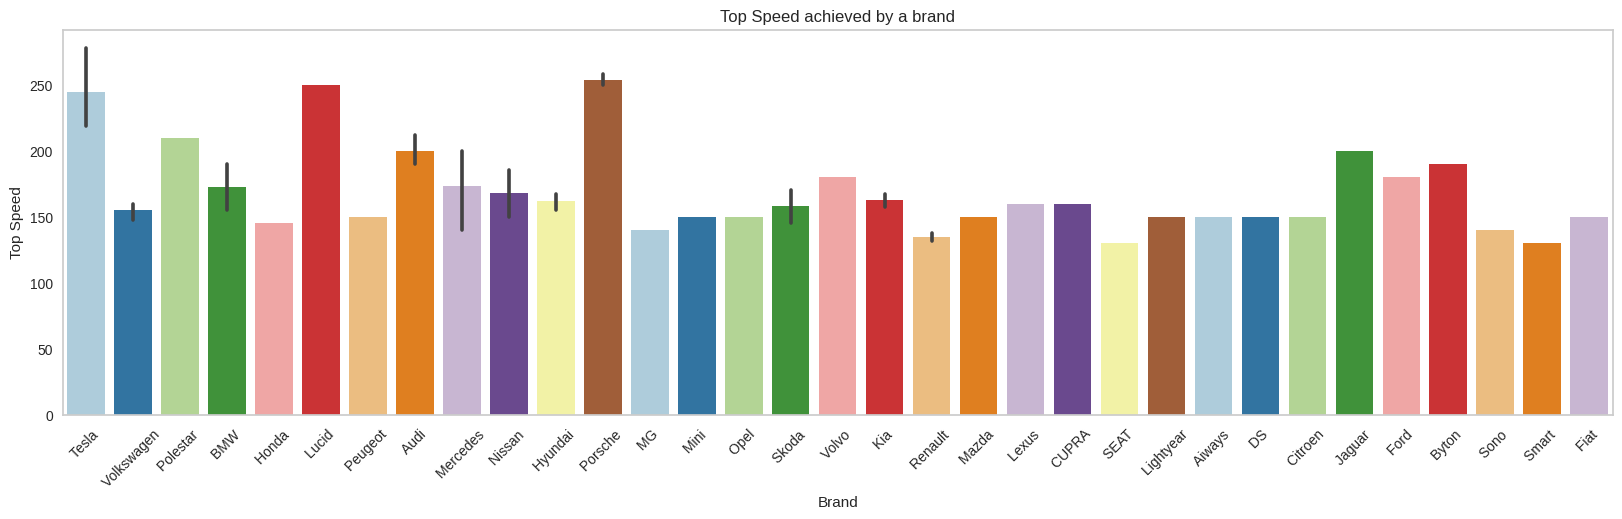

In [44]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='TopSpeed_KmH',data=df,palette='Paired')
plt.grid(axis='y')
plt.title('Top Speed achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Top Speed')
plt.xticks(rotation=45)

Porsche, Lucid and Tesla produce the fastest cars and Smart the lowest


## Range a car can achieve

<ipython-input-45-8ac9ad7b923f>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32

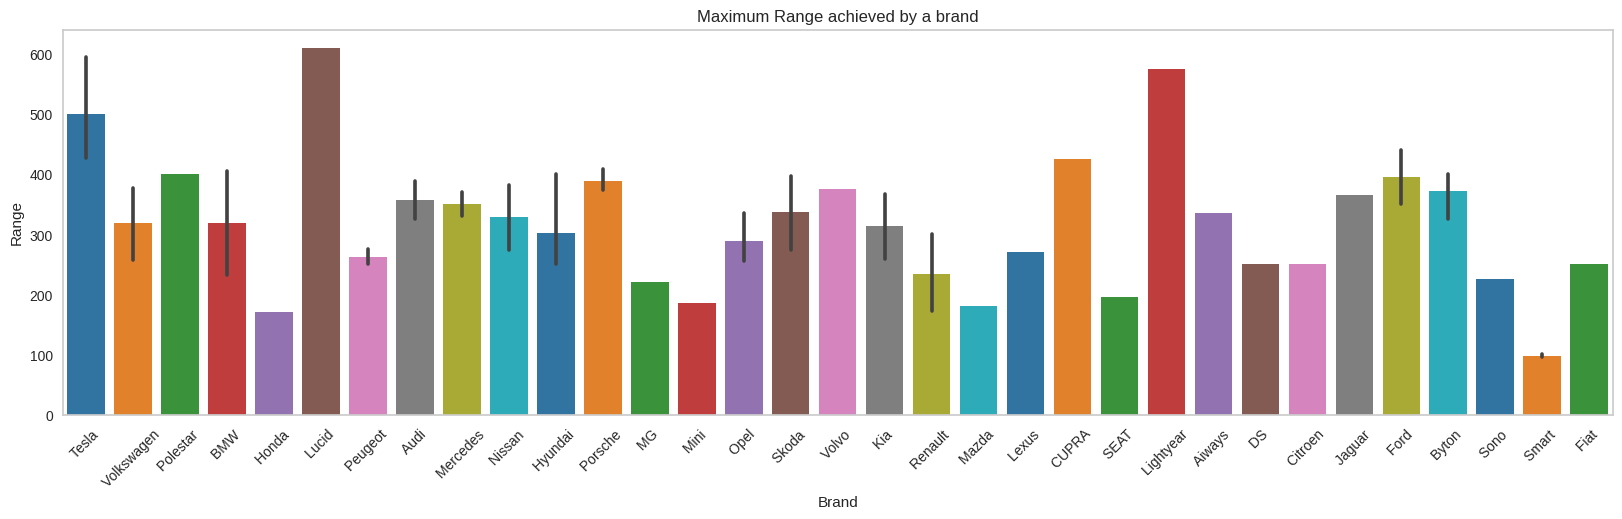

In [45]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Range_Km',data=df,palette='tab10')
plt.grid(axis='y')
plt.title('Maximum Range achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Range')
plt.xticks(rotation=45)

Lucid, Lightyear and Tesla have the highest range and Smart the lowest

## Car efficiency

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

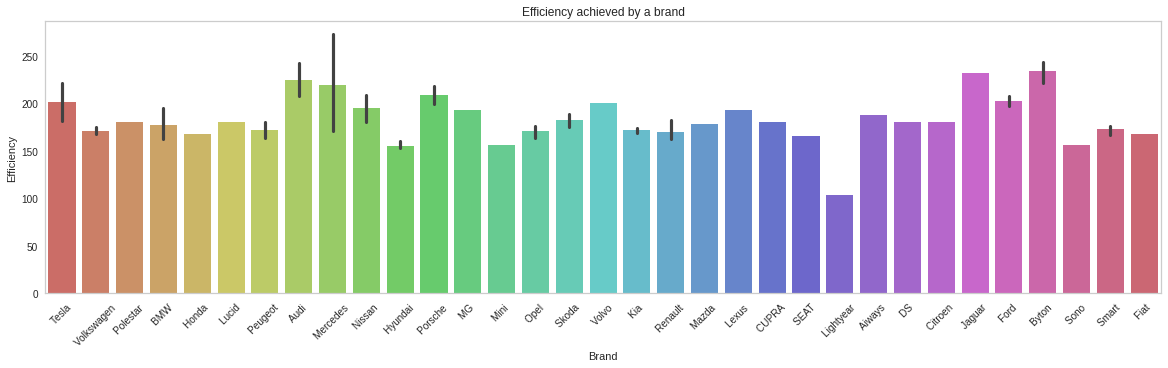

In [ ]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Efficiency_WhKm',data=df,palette='hls')
plt.grid(axis='y')
plt.title('Efficiency achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Efficiency')
plt.xticks(rotation=45)

Byton , Jaguar and Audi are the most efficient and Lightyear the least

## Number of seats in each car

<ipython-input-46-dbfd907a866b>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32

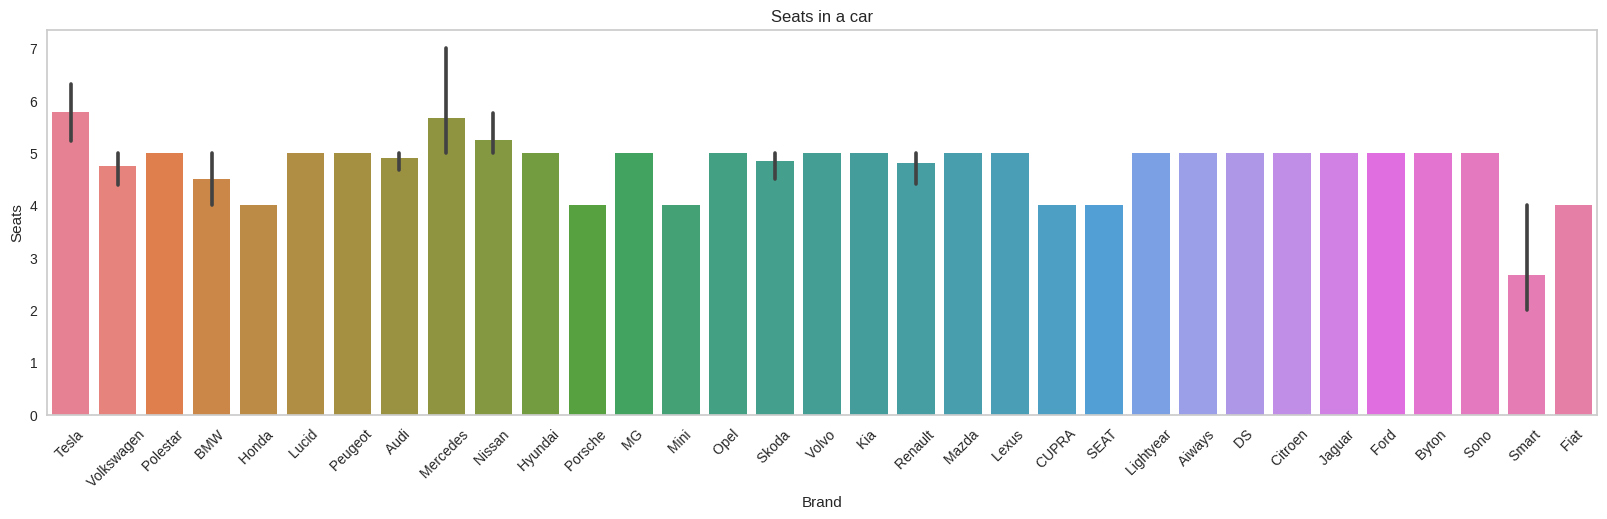

In [46]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Seats',data=df,palette='husl')
plt.grid(axis='y')
plt.title('Seats in a car')
plt.xlabel('Brand')
plt.ylabel('Seats')
plt.xticks(rotation=45)

Mercedes, Tesla and Nissan have the highest number of seats and Smart the lowest

## Price of cars (in INR)

<ipython-input-47-41d99b1ca110>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32

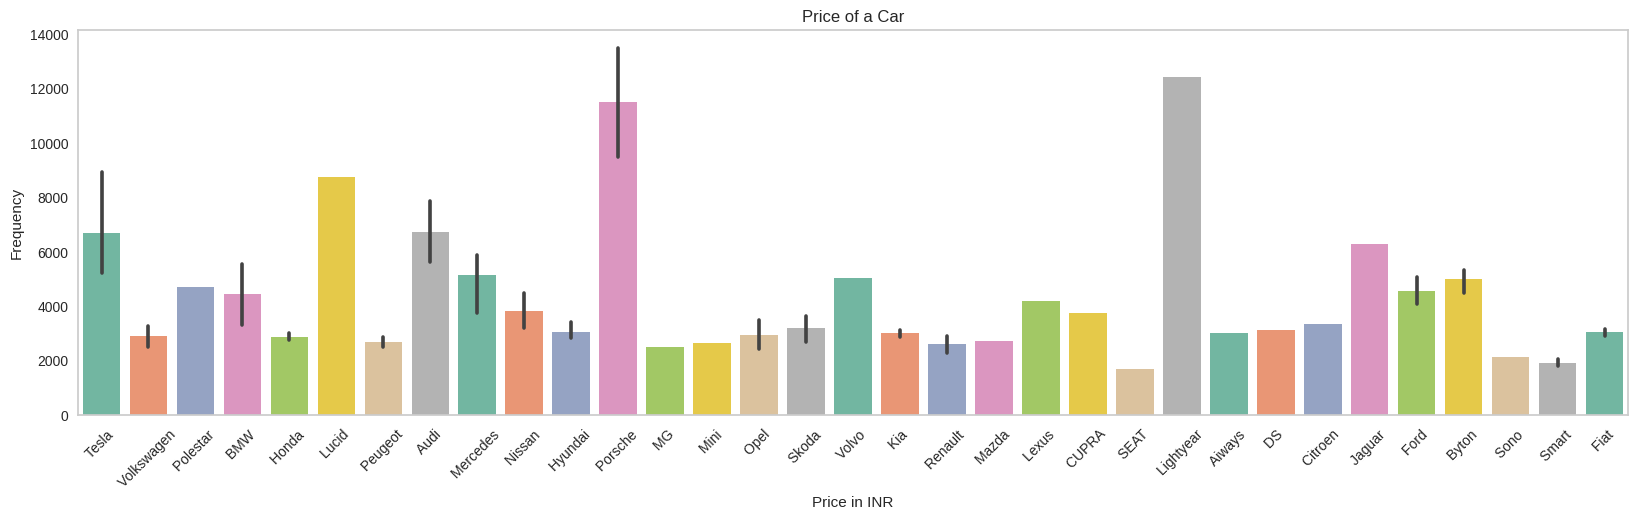

In [47]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='inr(10e3)',data=df,palette='Set2')
plt.title('Price of a Car')
plt.xlabel('Price in INR')
plt.grid(axis='y')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

Lightyear, Porsche and Lucid are the most expensive and SEAT and Smart the least

## Type of Plug used for charging

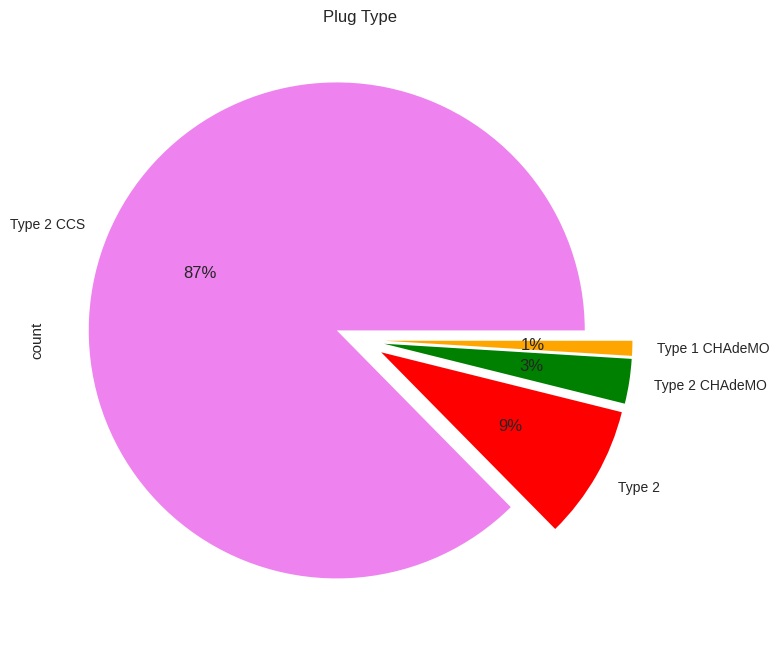

In [51]:
colors = ['violet', 'red', 'green', 'orange']  # Adjust the colors based on the number of unique plug types

df['PlugType'].value_counts().plot.pie(
    figsize=(8, 15),
    autopct='%.0f%%',
    explode=(0.1, 0.1, 0.1, 0.1),  # Adjust the explode values based on the number of unique plug types
    colors=colors
)

plt.title('Plug Type')
plt.show()


Most companies use Type 2 CCS and Type 1 CHAdeMo the least

## Cars and their body style

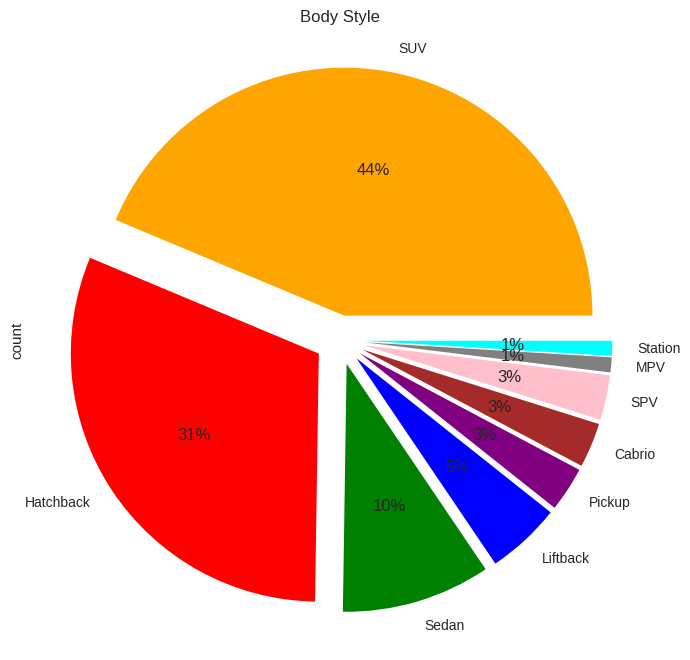

In [54]:
colors = [
    'orange', 'red', 'green', 'blue', 'purple', 'brown',
    'pink', 'gray', 'cyan'
]

df['BodyStyle'].value_counts().plot.pie(
    figsize=(8, 15),
    autopct='%.0f%%',
    explode=(0.1,) * len(colors),
    colors=colors
)

plt.title('Body Style')
plt.show()

Most cars are eiher SUV or Hatchback

## Segment in which the cars fall under

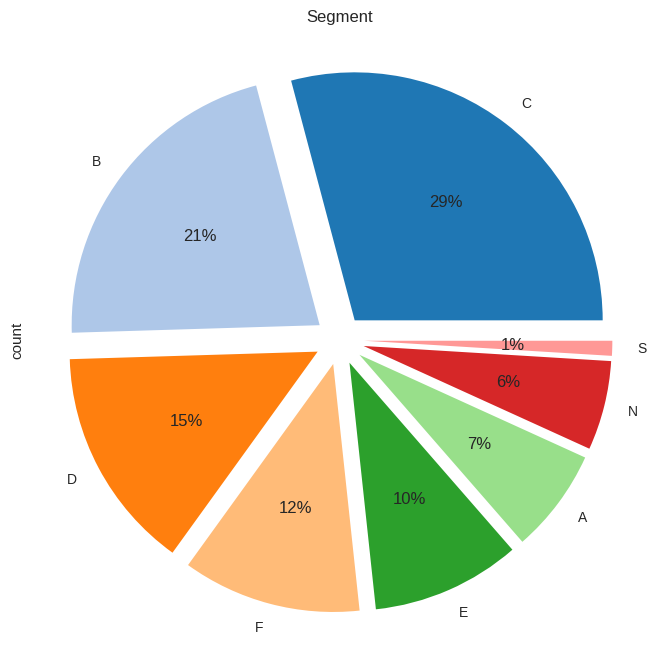

In [56]:
unique_segments = df['Segment'].value_counts()

colors = plt.cm.tab20.colors

explode = [0.1] * len(unique_segments)

plt.figure(figsize=(8, 15))
unique_segments.plot.pie(
    autopct='%.0f%%',
    explode=explode,
    colors=colors[:len(unique_segments)]
)

plt.title('Segment')
plt.show()

Most cars are either C or B type

## Number of Seats

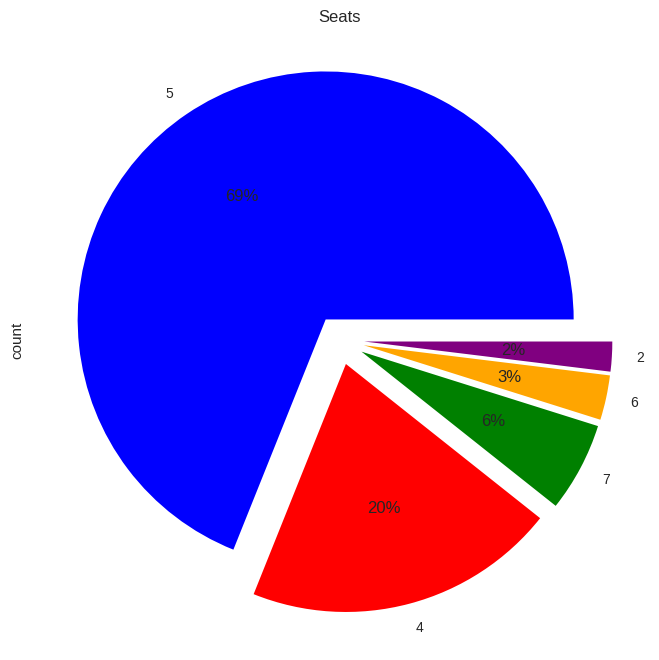

In [58]:
seat_counts = df['Seats'].value_counts()

colors = [
    'blue', 'red', 'green', 'orange', 'purple'  # Adjust this list based on the number of unique values
]

colors = colors[:len(seat_counts)]

explode = (0.1,) * len(seat_counts)  # Explode all slices equally

plt.figure(figsize=(8, 15))
seat_counts.plot.pie(
    autopct='%.0f%%',
    explode=explode,
    colors=colors
)

plt.title('Seats')
plt.show()

Majority of cars have 5 seats

In [59]:
df3= df[["TopSpeed_KmH", "inr(10e3)"]].groupby("TopSpeed_KmH").count()
df4= df[["Range_Km", "inr(10e3)"]].groupby("Range_Km").count()
df5= df[["Range_Km", "TopSpeed_KmH"]].groupby("Range_Km").count()
df5.head()

,TopSpeed_KmH
Range_Km,
95,2
100,1
130,1
160,1
170,2


In [60]:
df3=df3.sort_values("TopSpeed_KmH",ascending = False).head(10)
df4=df4.sort_values("Range_Km",ascending = False).head(10)
df5=df5.sort_values("Range_Km",ascending = False).head(10)

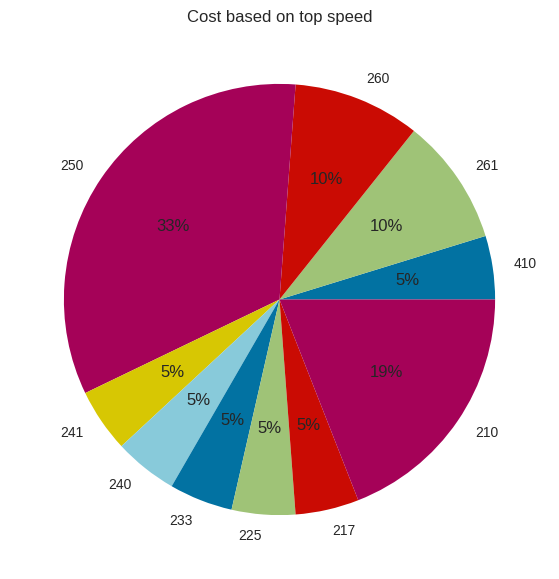

In [61]:
plt.figure(figsize=(10,7))
plt.title('Cost based on top speed')
plt.pie(x=df3["inr(10e3)"],labels=df3.index,autopct='%1.0f%%')
plt.show()

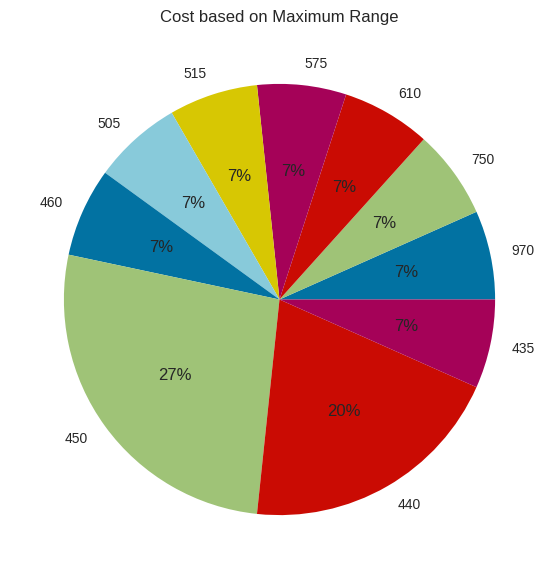

In [62]:
plt.figure(figsize=(10,7))
plt.title('Cost based on Maximum Range')
plt.pie(x=df4["inr(10e3)"],labels=df4.index,autopct='%1.0f%%')
plt.show()

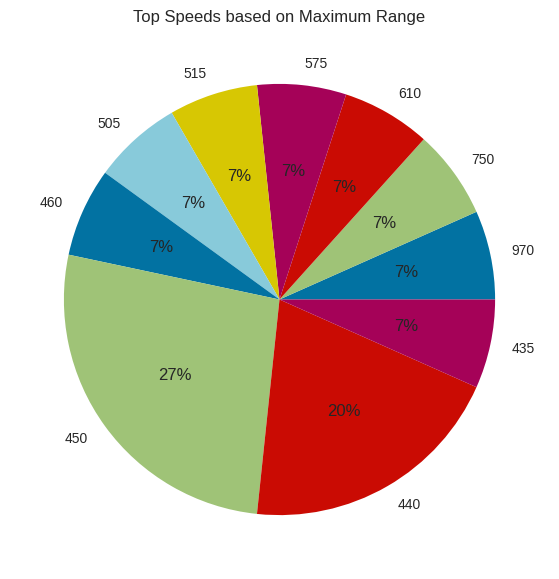

In [63]:
plt.figure(figsize=(10,7))
plt.title('Top Speeds based on Maximum Range')
plt.pie(x=df5["TopSpeed_KmH"],labels=df5.index,autopct='%1.0f%%')
plt.show()

# Regression

## Putting independent variables as x and dependent variable as y

In [64]:
df['PowerTrain'].replace(to_replace=['RWD','AWD','FWD'],value=[0, 2,1],inplace=True)
x=df[['AccelSec','Range_Km','TopSpeed_KmH','Efficiency_WhKm', 'RapidCharge','PowerTrain']]
y=df['PriceEuro']

## Finding out the linear regression using OLS method

In [65]:
x= sm.add_constant(x)
results = sm.OLS(y,x)

## Fitting the model and summarizing

In [66]:
model=results.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     41.36
Date:                Sat, 13 Jul 2024   Prob (F-statistic):           1.57e-24
Time:                        06:31:05   Log-Likelihood:                -1155.0
No. Observations:                 103   AIC:                             2324.
Df Residuals:                      96   BIC:                             2342.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.031e+05   2.38e+04     -4.324      0.000    -1.5e+05   -5.58e+04
AccelSec         1753.0004   1048.759      1.672      0.098    -328.769    3834.770
Range_Km           36.3000     22.629      1.604      0.112      -8.618      81.218
TopSpeed_KmH      581.7484     80.158      7.257      0.000     422.636     740.861
Efficiency_WhKm   117.6685     70.307      1.674      0.097     -21.890     257.227
RapidCharge      1465.5687   4496.958      0.326      0.745   -7460.822    1.04e+04
PowerTrain       5235.8309   2956.235      1.771      0.080    -632.248    1.11e+04
==============================================================================
Omnibus:                       84.867   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              741.645
Skew:                           2.644   Prob(JB):                    8.99e-162
Kurtosis:                      15.036   Cond. No.                     5.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Notes:

1. Standard Errors assume that the covariance matrix of the errors is correctly specified.
2. The condition number is large, 5.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

Only Top Speed and Efficieny are the two variables related to price

In [67]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=365)

In [68]:
lr= LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

## Finding out the R-squared value

In [69]:
r2=(r2_score(y_test,pred))
print(r2*100)

78.77072380232661


Around 78% of the dependant variable has been explained by the independant variables

In [70]:
y1=df[['RapidCharge']]
x1=df[['PriceEuro']]

In [71]:
X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2,random_state=365)

In [72]:
log= LogisticRegression()
log.fit(X1_train, y1_train)
pred1 = log.predict(X1_test)
pred1

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Confusion Matrix of the regression

In [73]:
cm = confusion_matrix(y1_test, pred1)
cm

array([[ 0,  6],
       [ 0, 15]])

## Clustering

<Axes: xlabel='TopSpeed_KmH', ylabel='FastCharge_KmH'>

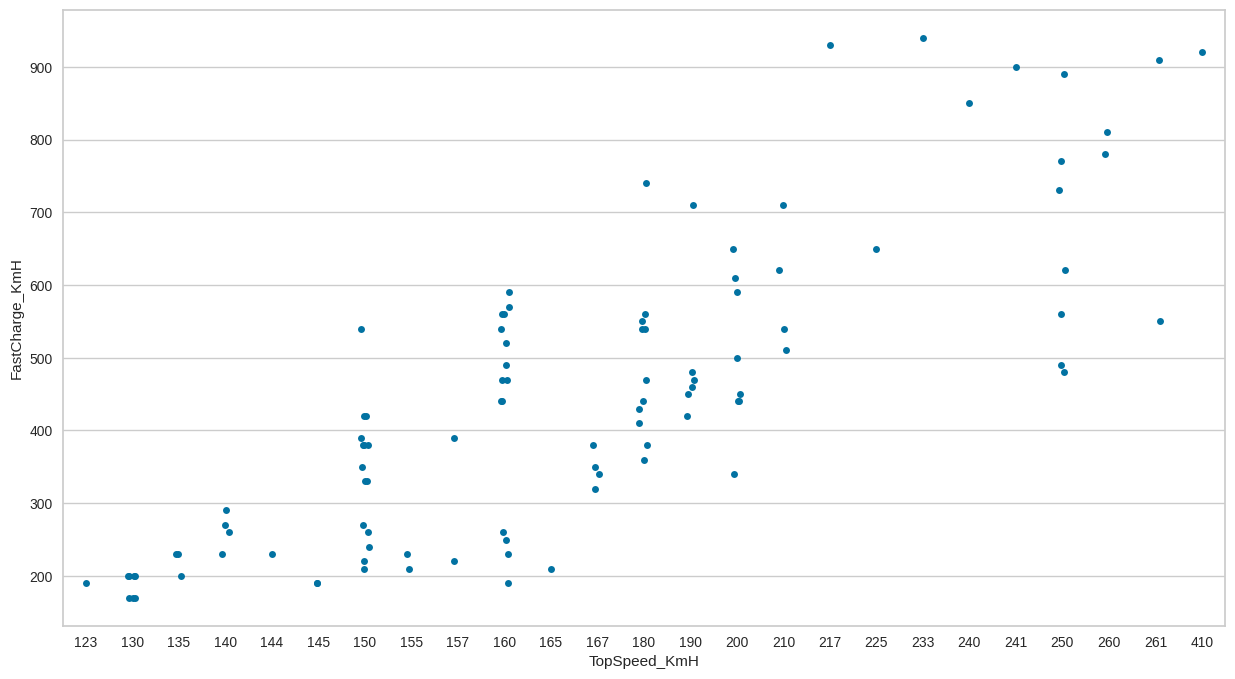

In [74]:
ax=plt.subplots(figsize=(15,8))
sb.stripplot(x='TopSpeed_KmH', y='FastCharge_KmH', data=df, jitter=True)

<Axes: xlabel='TopSpeed_KmH', ylabel='Efficiency_WhKm'>

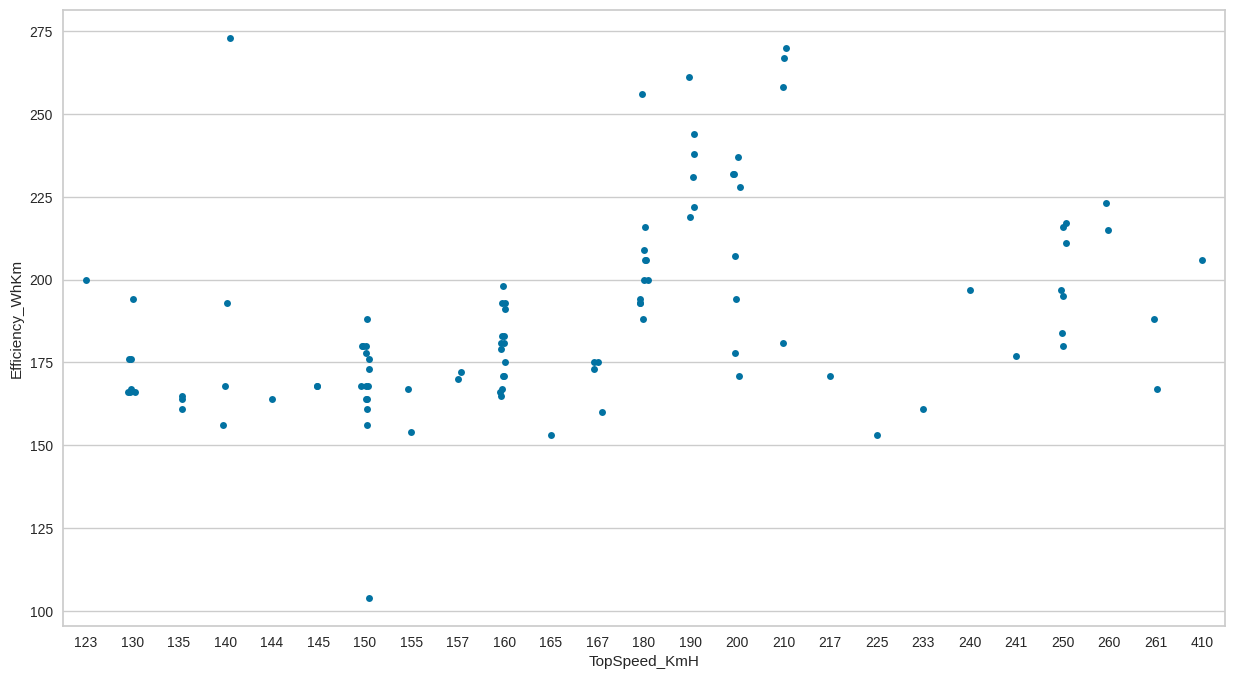

In [75]:
ax=plt.subplots(figsize=(15,8))
sb.stripplot(x='TopSpeed_KmH', y='Efficiency_WhKm', data=df, jitter=True)

In [76]:
features = ['AccelSec','TopSpeed_KmH','Efficiency_WhKm','FastCharge_KmH', 'RapidCharge','Range_Km', 'Seats', 'inr(10e3)','PowerTrain']
# Separating out the features
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)

In [77]:
pca = PCA(n_components=9)
t = pca.fit_transform(x)
data2 = pd.DataFrame(t, columns=['PC1', 'PC2','PC3','PC4','Pc5','PC6', 'PC7', 'PC8','PC9'])
data2

,PC1,PC2,PC3,PC4,Pc5,PC6,PC7,PC8,PC9
0,2.4292,-0.5546,-1.1478,-0.8828,0.8400,-0.9593,0.9989,0.7111,-0.3967
1,-2.3225,-0.3454,0.8965,-1.3055,0.0796,0.2351,-0.2137,-0.5441,-0.1819
2,1.5879,0.0089,-0.6505,0.0410,0.5935,-0.6982,0.0587,0.2488,-0.2028
3,0.2910,-0.0001,-0.3077,-0.5142,-1.6089,0.2916,0.3650,-0.2355,0.2617
4,-2.6027,-0.6265,-0.8881,0.5853,-0.8021,0.0274,-0.0850,-0.5078,-0.0499
...,...,...,...,...,...,...,...,...,...
98,-0.2972,0.4467,-0.4636,0.1025,-0.3460,-0.1005,0.0311,0.2023,0.1454
99,2.3350,0.6307,0.9859,1.5601,-0.8173,-0.1219,0.1641,-0.2557,0.1410
100,0.7806,0.4268,-0.2986,0.7086,0.4817,-0.5401,-0.1398,-0.0487,-0.3675
101,1.5409,0.6988,0.4224,1.0949,-0.2981,-0.3080,-0.3632,0.1273,-0.1904


In [78]:
df_9=data2.iloc[:,:9]
df_9.head(3)

,PC1,PC2,PC3,PC4,Pc5,PC6,PC7,PC8,PC9
0,2.4292,-0.5546,-1.1478,-0.8828,0.8400,-0.9593,0.9989,0.7111,-0.3967
1,-2.3225,-0.3454,0.8965,-1.3055,0.0796,0.2351,-0.2137,-0.5441,-0.1819
2,1.5879,0.0089,-0.6505,0.0410,0.5935,-0.6982,0.0587,0.2488,-0.2028


In [79]:
# correlation coefficient between original variables and the component
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_9.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning:

Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
variable,,,,,,,,,
PC1,-0.3964,0.0862,0.0648,0.0583,0.1445,0.6769,0.4125,0.2707,-0.3246
PC2,0.4220,-0.2168,0.0023,-0.0685,0.0382,0.0452,0.0376,-0.4138,-0.7708
PC3,0.2383,0.3309,0.5718,0.3805,-0.5751,0.0249,0.0047,0.1442,-0.0990
PC4,0.3945,-0.1384,-0.0477,-0.2965,-0.0924,-0.2379,0.7282,0.3584,0.1057
Pc5,0.1572,0.2699,-0.8033,0.3953,-0.2926,0.0870,0.0539,0.0408,-0.0561
PC6,0.3895,-0.0247,-0.0763,-0.3871,-0.0328,0.3645,-0.5208,0.5342,-0.0380
PC7,0.1404,0.8013,0.0195,-0.4290,0.1653,0.0867,0.0984,-0.3208,0.0800
PC8,0.3898,-0.2623,0.0738,0.1799,0.0433,0.5587,0.1180,-0.3821,0.5172
PC9,0.3229,0.1805,0.0983,0.4866,0.7228,-0.1499,-0.0191,0.2653,-0.0333


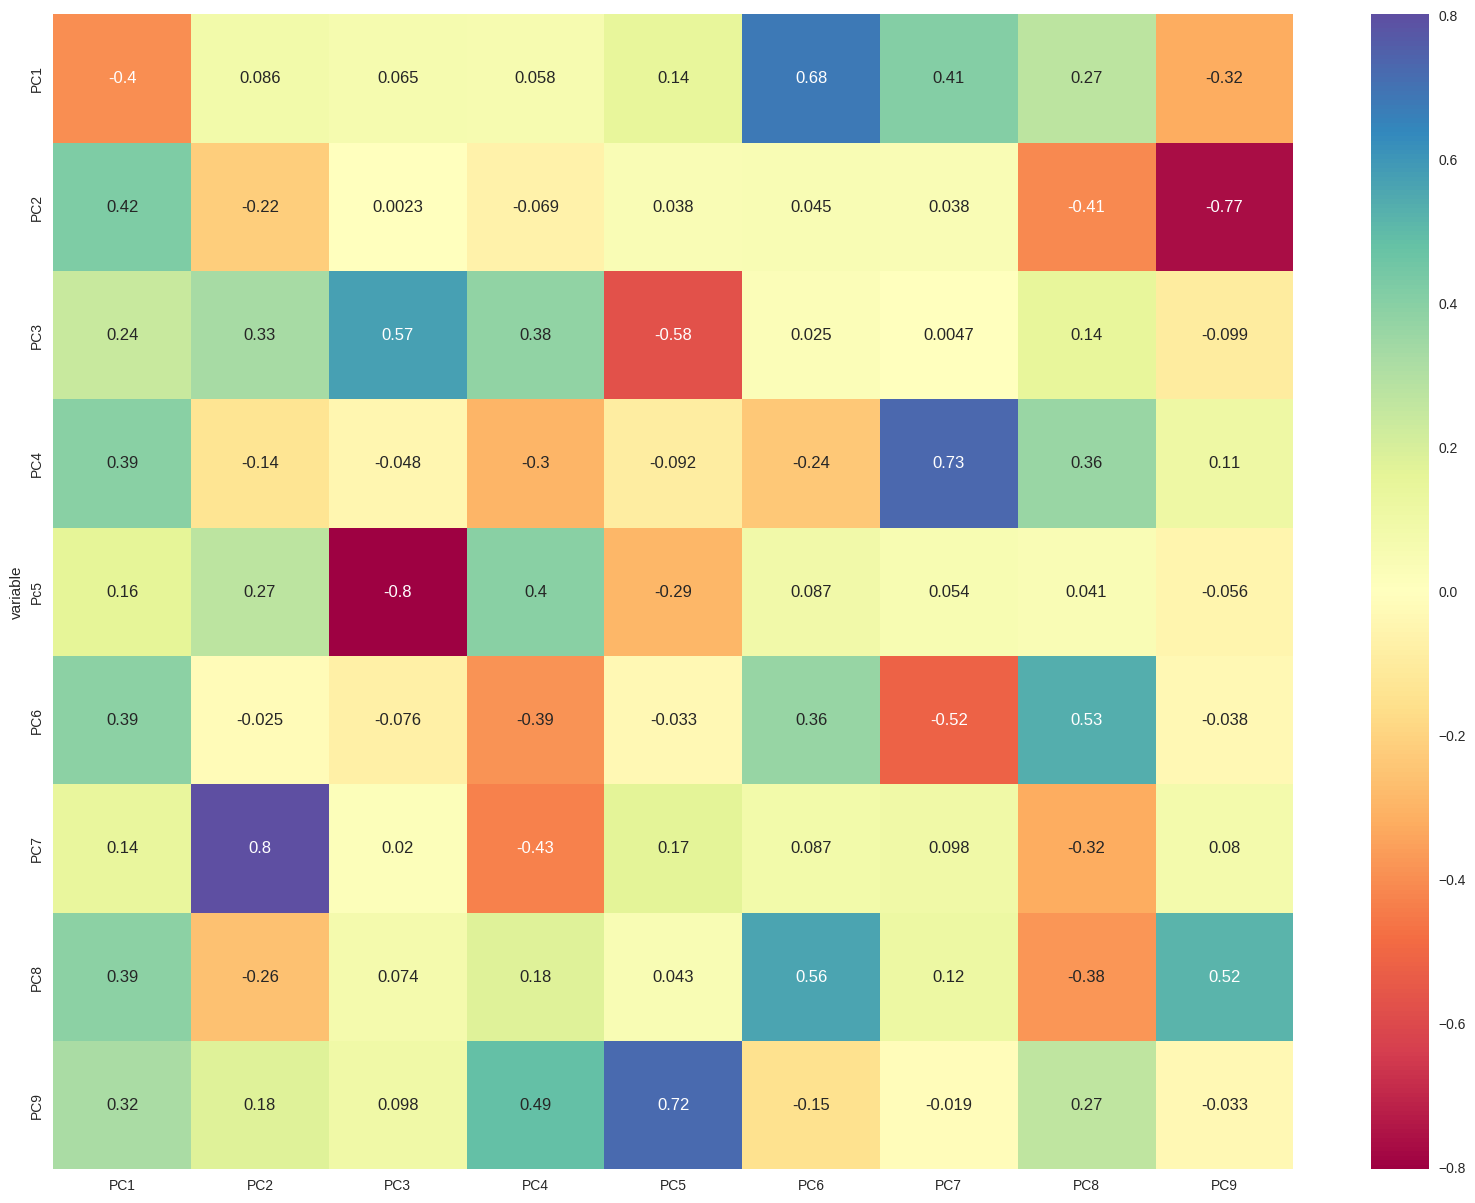

In [80]:
#Correlation matrix plot for loadings
plt.rcParams['figure.figsize'] = (20,15)
ax = sb.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

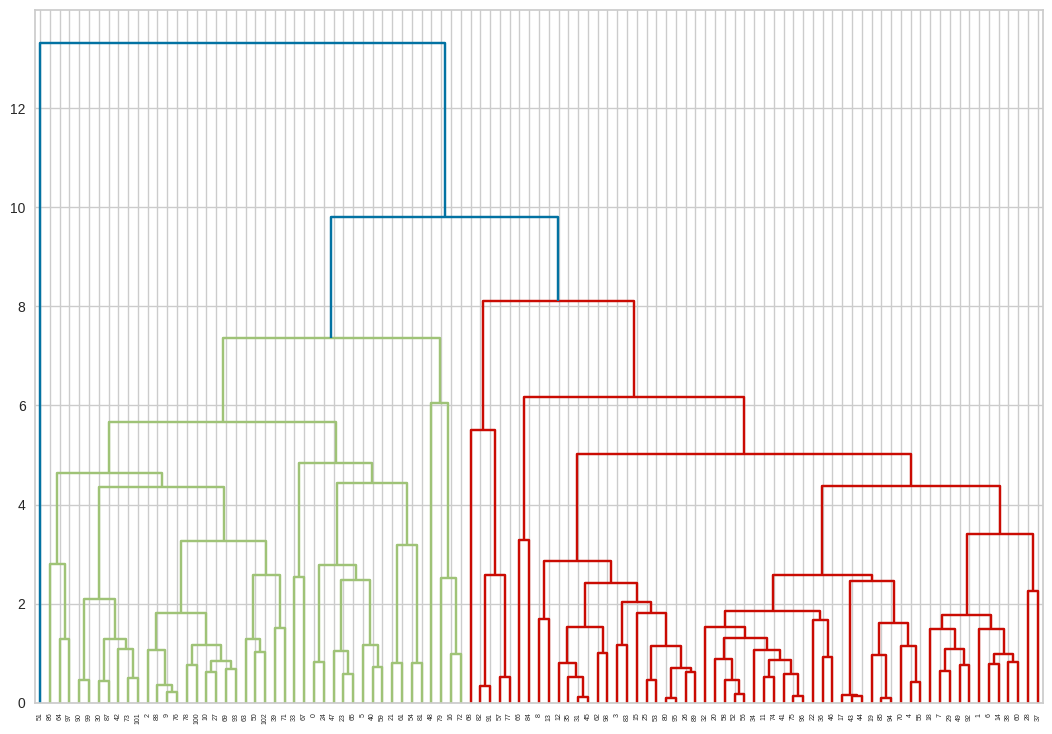

In [82]:
linked = linkage(data2, 'complete')
plt.figure(figsize=(13, 9))
dendrogram(linked, orientation='top')
plt.show()

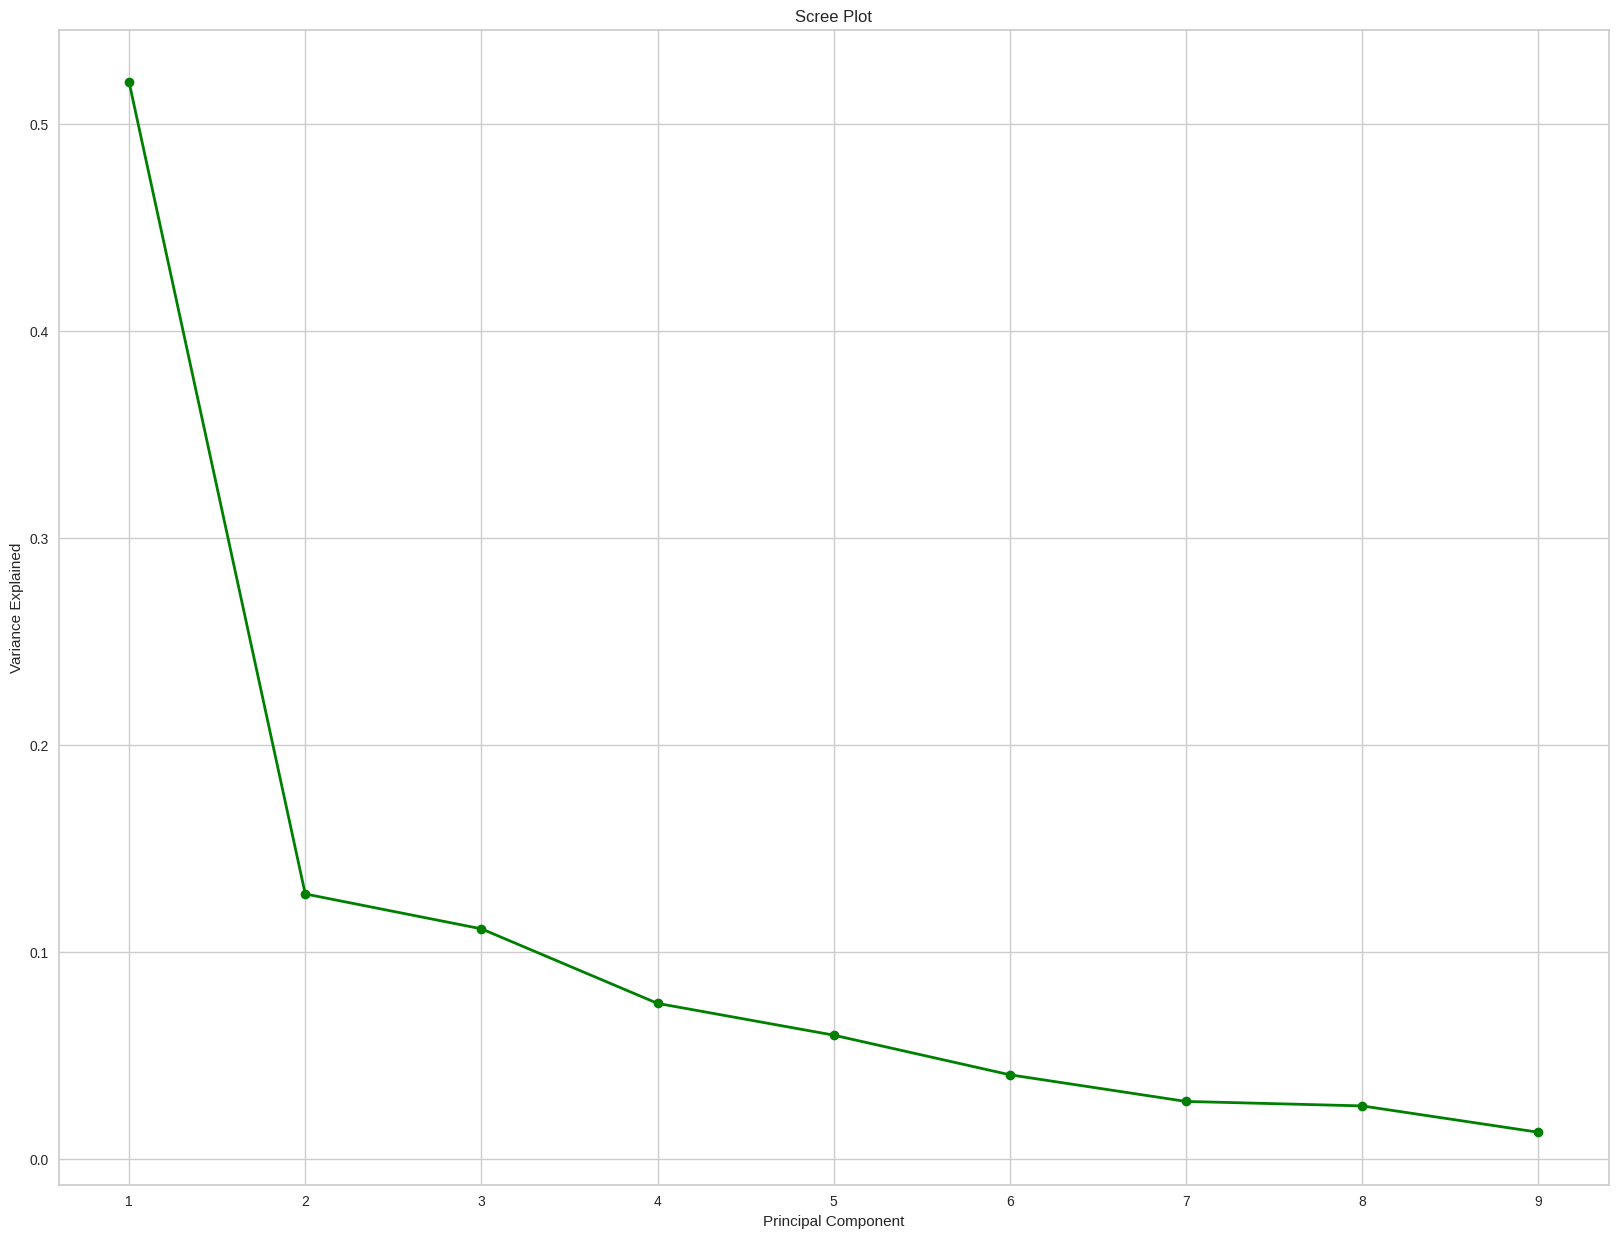

In [83]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='green')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

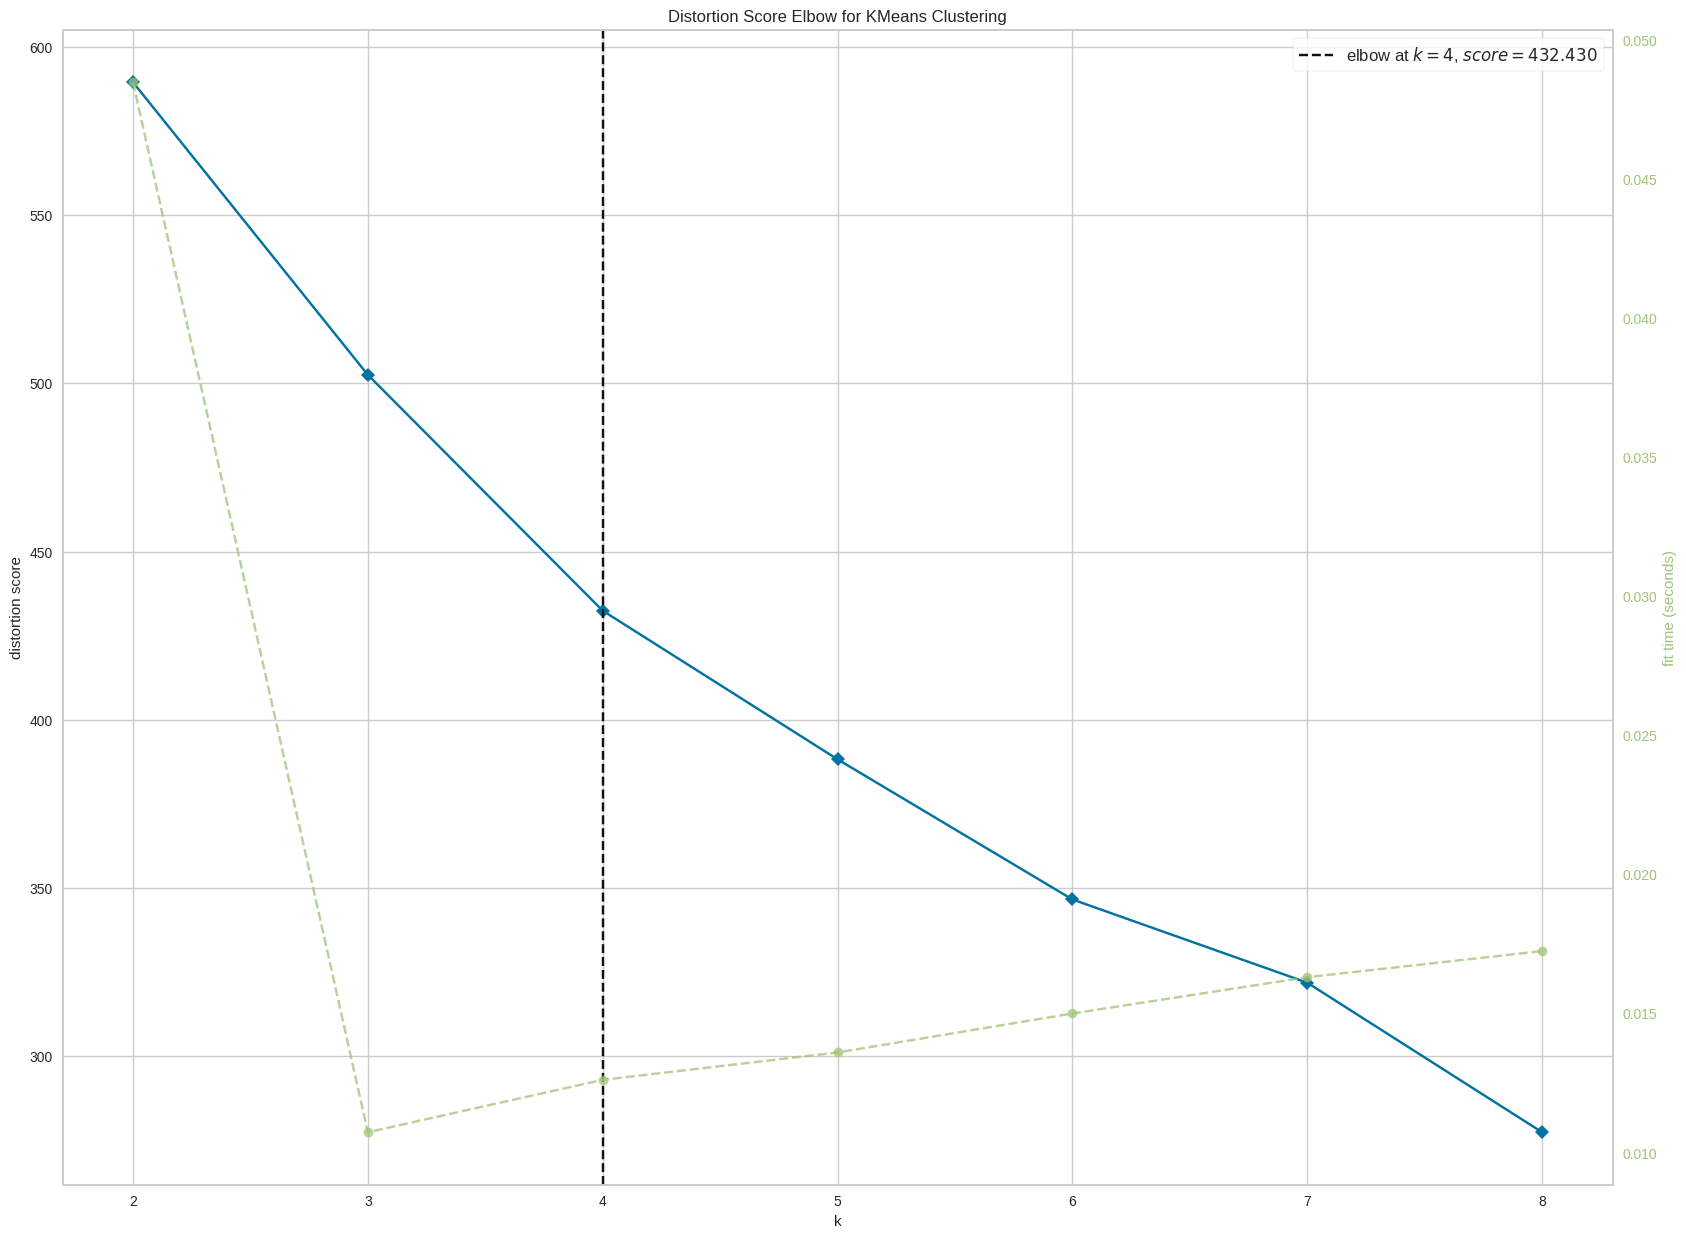

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [84]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='distortion', timings=True)
visualizer.fit(t)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

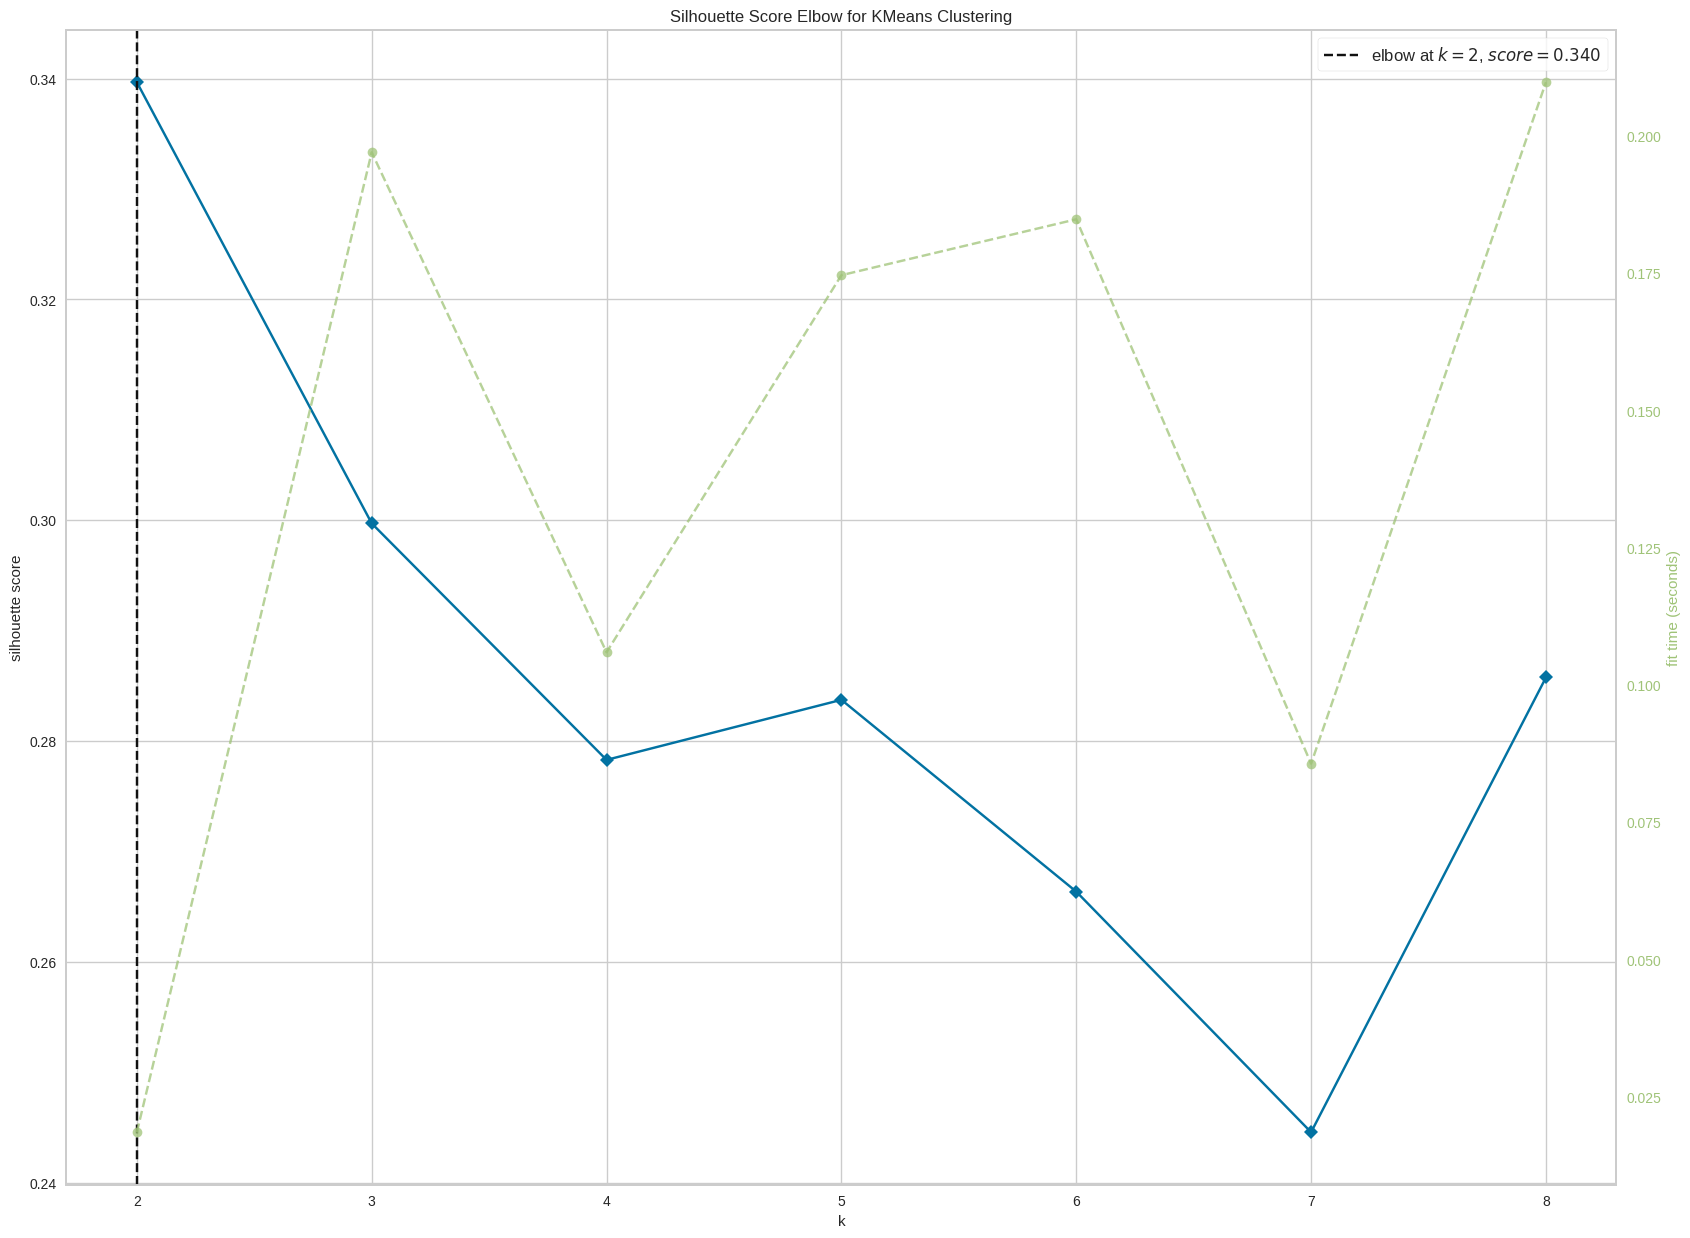

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [85]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='silhouette', timings=True)
visualizer.fit(t)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

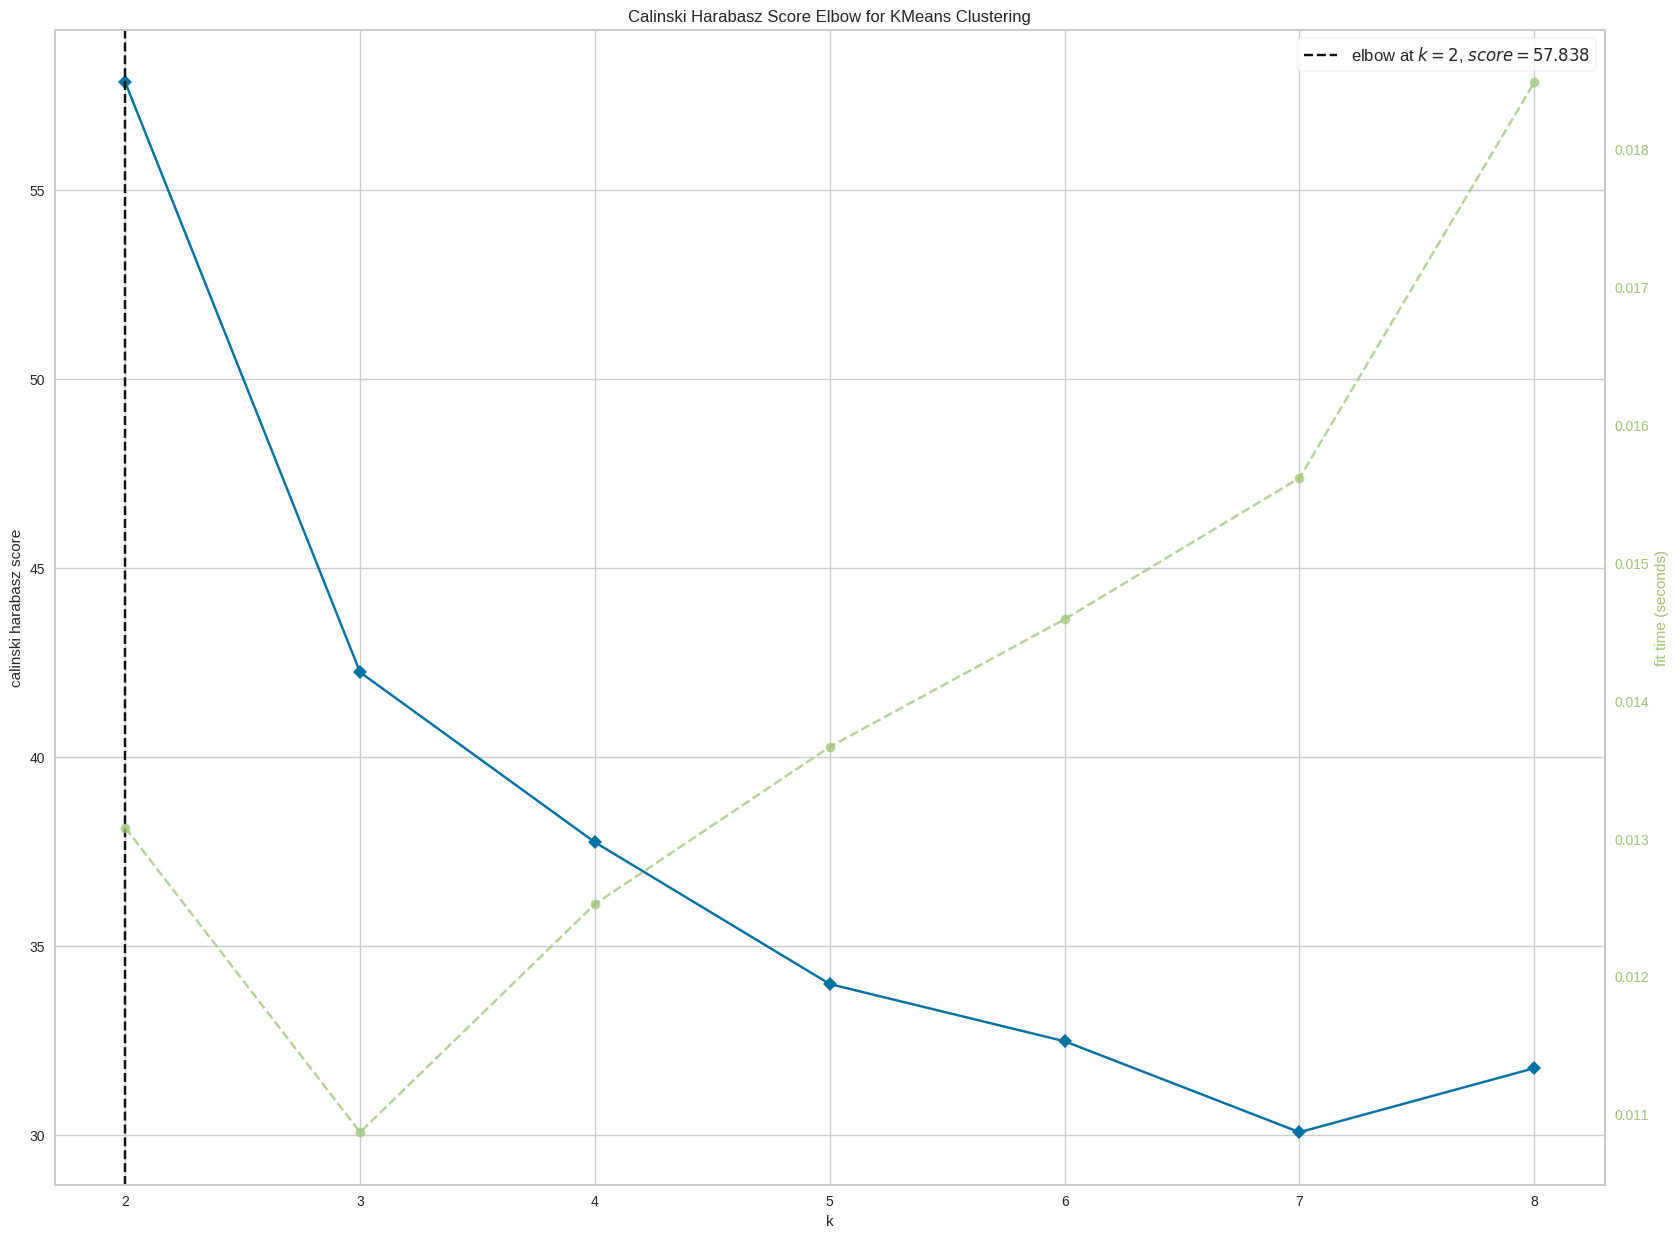

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [86]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='calinski_harabasz', timings=True)
visualizer.fit(t)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [87]:
#K-means clustering

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(t)
df['cluster_num'] = kmeans.labels_ #adding to df
print (kmeans.labels_) #Label assigned for each data point
print (kmeans.inertia_) #gives within-cluster sum of squares.
print(kmeans.n_iter_) #number of iterations that k-means algorithm runs to get a minimum within-cluster sum of squares
print(kmeans.cluster_centers_) #Location of the centroids on each cluster.

[0 3 2 1 1 0 3 3 1 2 2 1 1 2 3 1 0 1 3 1 1 2 1 0 0 1 1 2 3 3 2 1 1 2 1 1 1
 3 3 2 0 1 2 1 1 1 1 0 0 3 2 0 1 1 2 1 1 3 1 0 3 2 2 2 3 0 1 2 3 2 1 2 0 2
 1 1 2 3 2 0 1 2 3 1 2 1 2 2 2 1 2 3 3 2 1 1 1 3 1 2 2 2 2]
427.887468451736
5
[[ 3.38081 -1.38223 -0.36489  0.10477  0.40601  0.27185  0.242   -0.10662
   0.04313]
 [-1.28035  0.15751 -0.8038   0.03883 -0.26171  0.05765 -0.02518 -0.04843
  -0.00967]
 [ 1.4734   0.75533  0.44439  0.22305  0.00588 -0.20901 -0.0464   0.13708
   0.00747]
 [-2.16662 -0.64972  1.15112 -0.52704  0.2495   0.04766 -0.03575 -0.0585
  -0.02224]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [88]:
#To see each cluster size

Counter(kmeans.labels_)

Counter({0: 13, 3: 19, 2: 32, 1: 39})

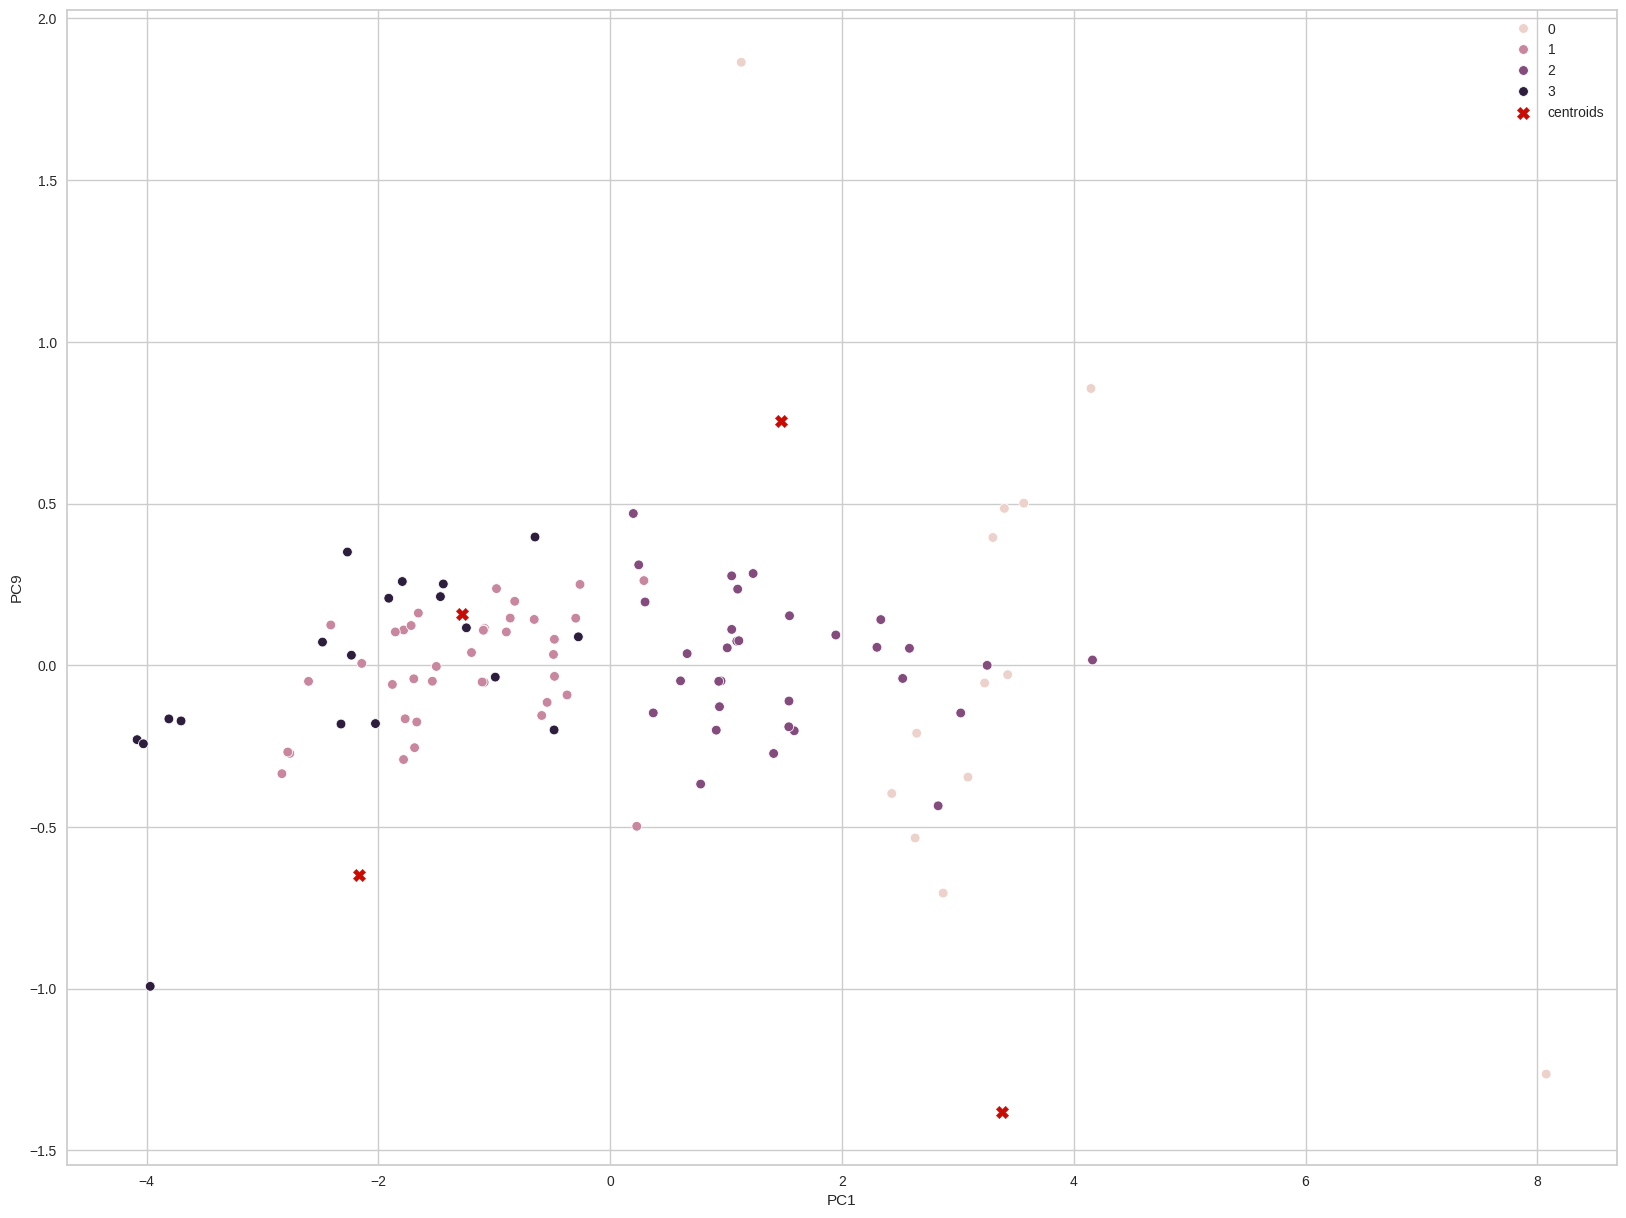

In [89]:
#Visulazing clusters
sb.scatterplot(data=data2, x="PC1", y="PC9", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()

## Regression for data2

In [90]:
X=data2[['PC1', 'PC2','PC3','PC4','Pc5','PC6', 'PC7','PC8','PC9']]
y=df['inr(10e3)']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4, random_state=101)
lm=LinearRegression().fit(X_train,y_train)

In [92]:
print(lm.intercept_)

4643.522050485438


In [93]:
lm.coef_

array([ 1101.58721,  -741.20904,   208.53617,   508.32246,   122.3533 ,
        1579.00686,   333.61147, -1079.99512,  1461.72269])

In [94]:
X_train.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'Pc5', 'PC6', 'PC7', 'PC8', 'PC9'], dtype='object')

In [95]:
cdf=pd.DataFrame(lm.coef_, X.columns, columns=['Coeff'])
cdf

,Coeff
PC1,1101.5872
PC2,-741.2090
PC3,208.5362
PC4,508.3225
Pc5,122.3533
PC6,1579.0069
PC7,333.6115
PC8,-1079.9951
PC9,1461.7227


In [96]:
predictions=lm.predict(X_test)
predictions

array([ 3744.    ,  2496.    ,  5233.28  ,  3243.7184,  3064.8384,
        5459.584 ,  2903.68  ,  3328.    ,  3952.    ,  2594.5088,
        2654.08  ,  3744.    ,  2041.2288, 15040.9792,  6609.824 ,
        3170.336 ,  4451.2   ,  2866.9888,  3744.    , 17888.    ,
        4877.184 ,  5660.928 ,  5876.4992,  2062.528 , 12396.8   ,
        8565.024 , 12338.6432,  3328.    ,  4695.808 ,  5408.    ,
        3064.8384,  3120.    ,  2826.3872, 10400.    ,  2745.6   ,
        2912.    ,  3153.28  ,  5028.3584,  2424.9472,  2766.0672,
        5604.1856,  3098.1184])

In [97]:
y_test

37    3744.0000
1     2496.0000
69    5233.2800
80    3243.7184
92    3064.8384
61    5459.5840
85    2903.6800
53    3328.0000
88    3952.0000
32    2594.5088
6     2654.0800
71    3744.0000
43    2041.2288
16   15040.9792
50    6609.8240
31    3170.3360
97    4451.2000
14    2866.9888
25    3744.0000
51   17888.0000
21    4877.1840
3     5660.9280
84    5876.4992
57    2062.5280
48   12396.8000
47    8565.0240
79   12338.6432
58    3328.0000
2     4695.8080
13    5408.0000
45    3064.8384
89    3120.0000
41    2826.3872
23   10400.0000
26    2745.6000
22    2912.0000
94    3153.2800
27    5028.3584
20    2424.9472
66    2766.0672
30    5604.1856
35    3098.1184
Name: inr(10e3), dtype: float64

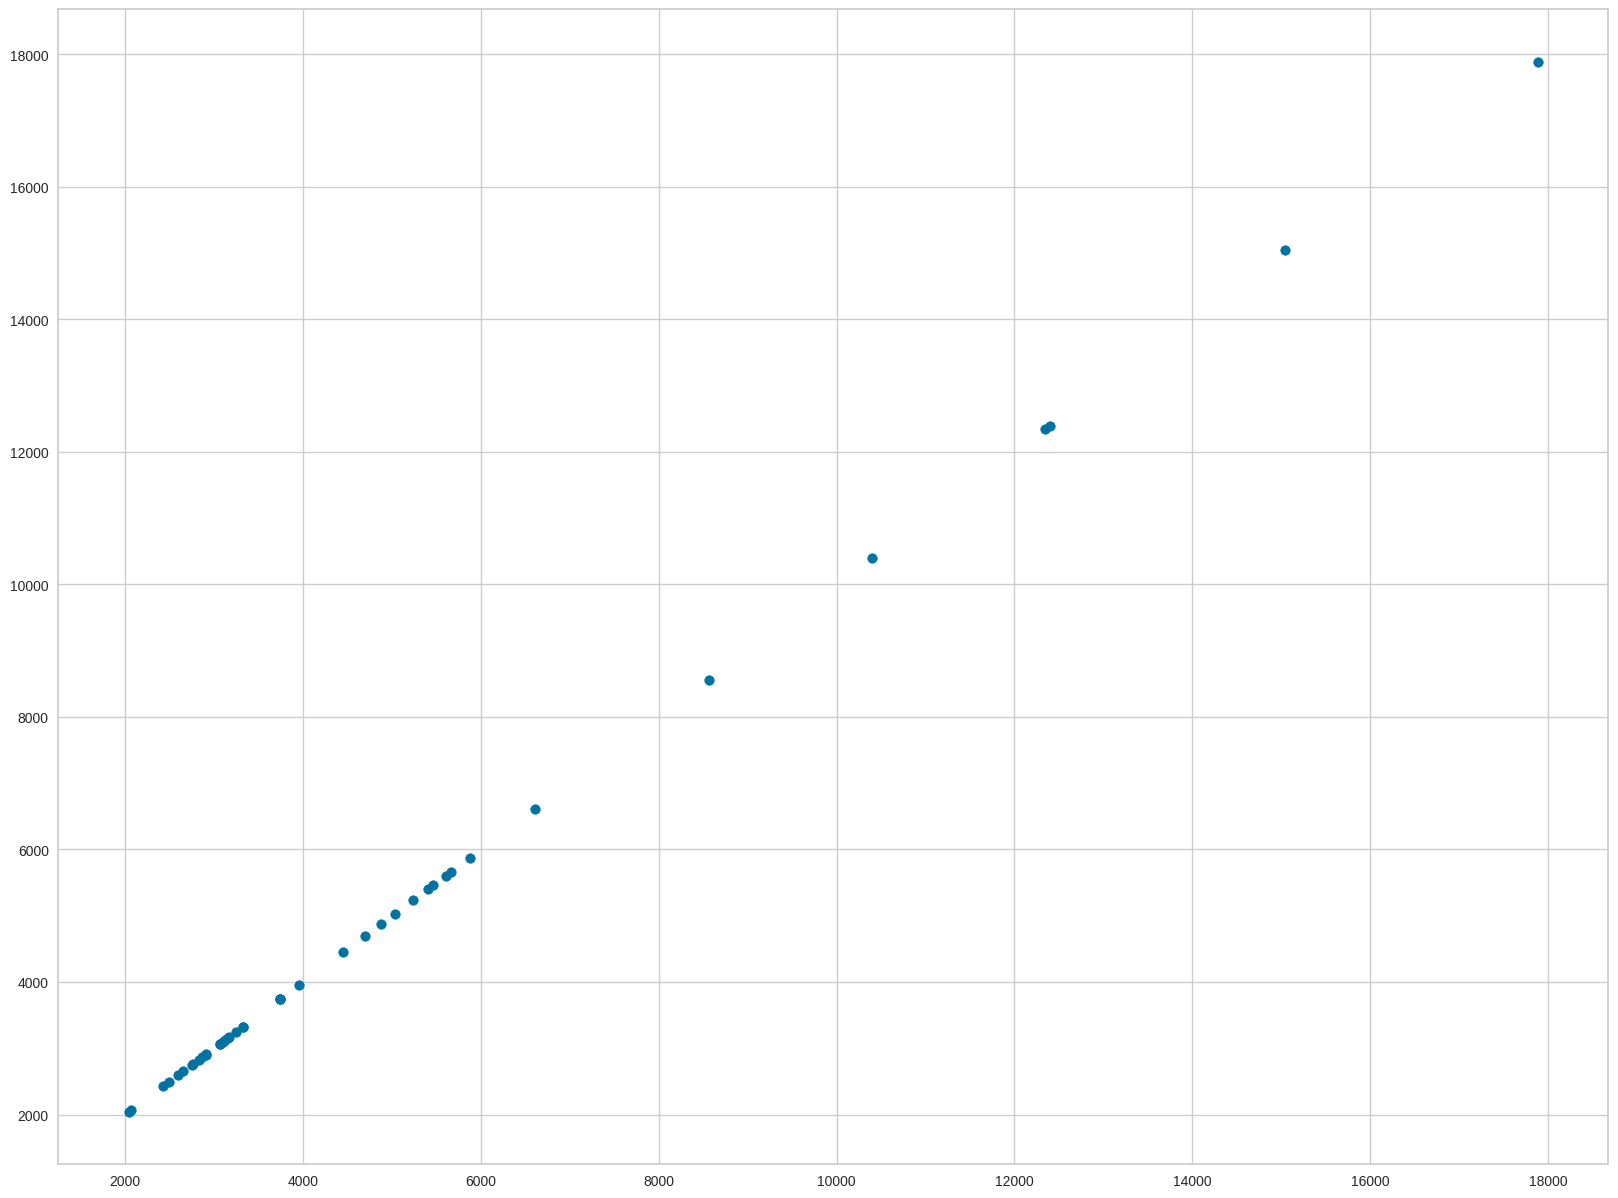

In [98]:
plt.scatter(y_test, predictions)

<ipython-input-99-ec1b9bc3fd2e>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='inr(10e3)', ylabel='Density'>

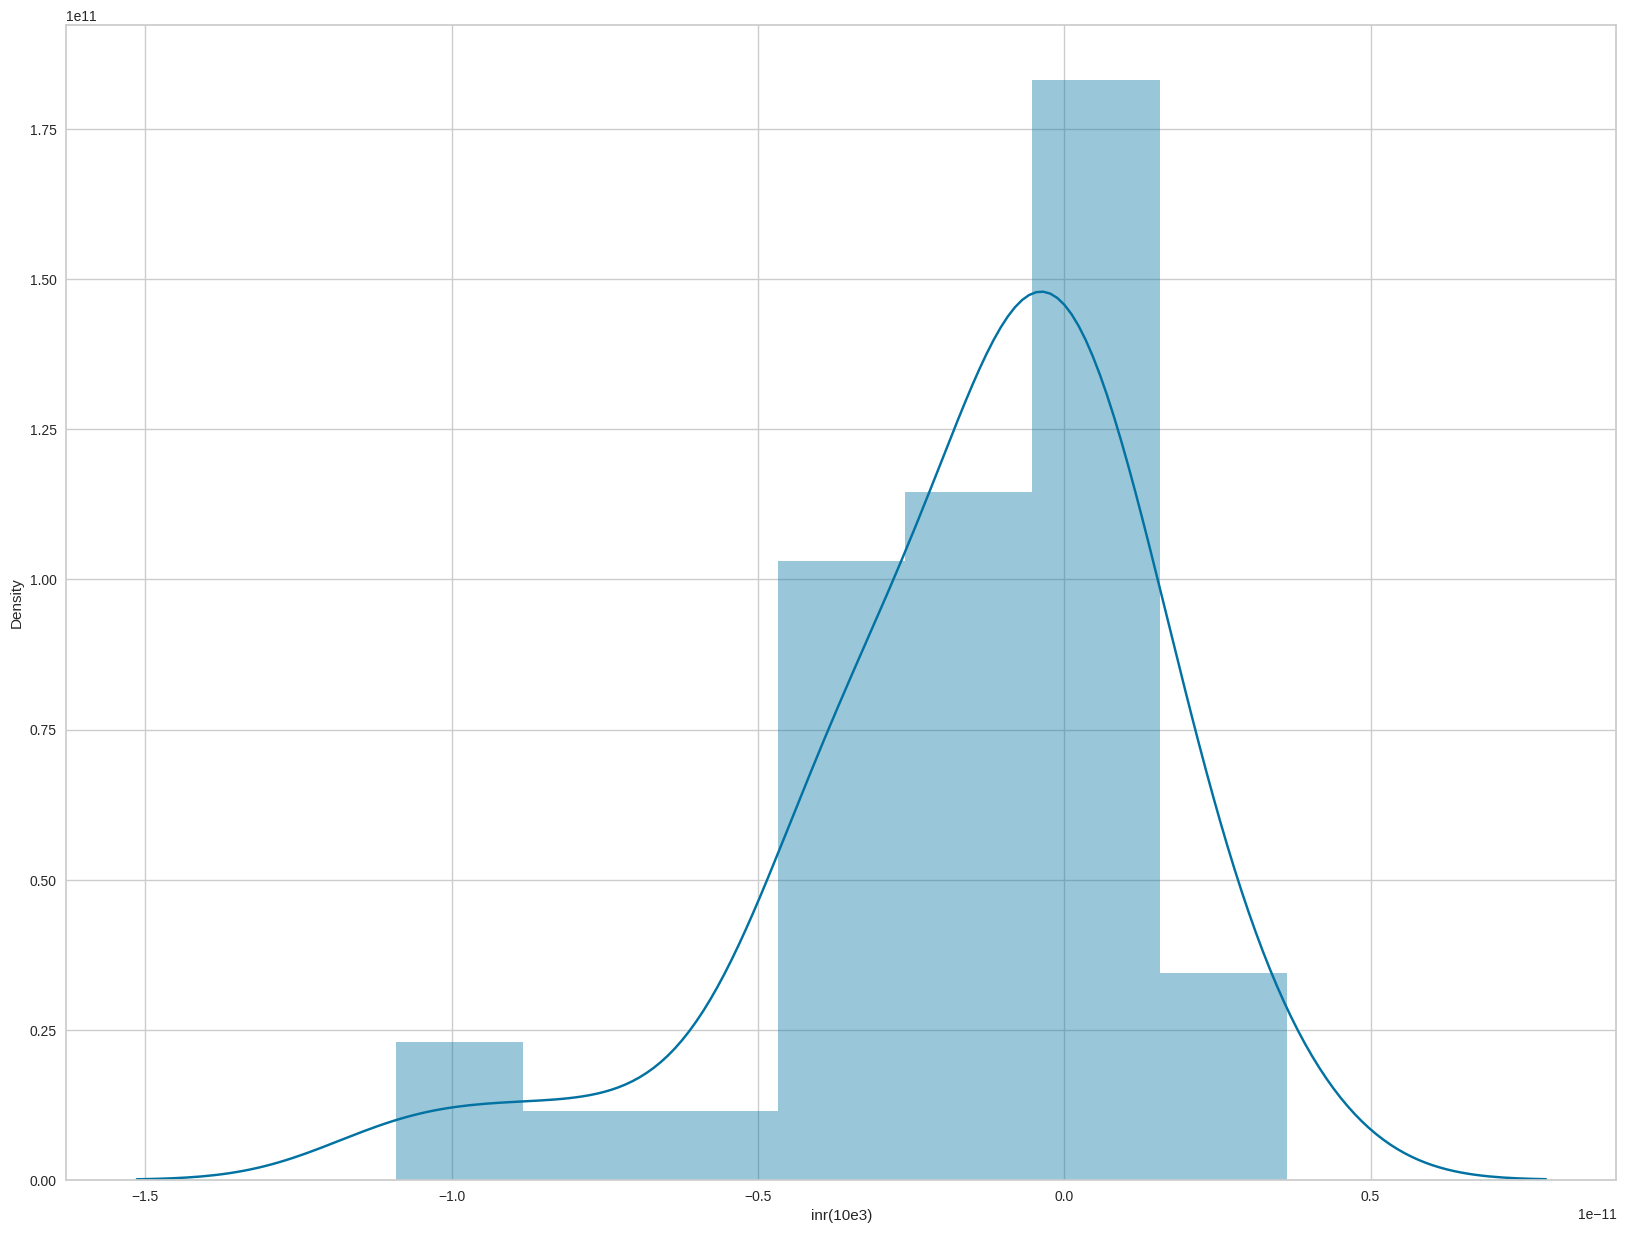

In [99]:
#Residual histogram plot
sb.distplot((y_test-predictions))

In [100]:
print('MAE:',metrics.mean_absolute_error(y_test,predictions))
print('MSE:',metrics.mean_squared_error(y_test,predictions))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,predictions)))

MAE: 2.2629094365540715e-12
MSE: 1.0768119045556378e-23
RMSE: 3.281481227366138e-12


In [101]:
metrics.mean_absolute_error(y_test,predictions)

2.2629094365540715e-12

In [102]:
metrics.mean_squared_error(y_test,predictions)

1.0768119045556378e-23

In [103]:
np.sqrt(metrics.mean_squared_error(y_test,predictions))

3.281481227366138e-12